## Table of contents

* Purpose
* Dataset
    * General properties
    * Missing Values
    * Numerical attributes and outliers
    * Categorical attributes and outliers

## Purpose
In this competition you will predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. The data included text, tabular, and image data. See below for details. 
This is a Kernels-only competition. At the end of the competition, test data will be replaced in their entirety with new data of approximately the same size, and your kernels will be rerun on the new data.

**File descriptions**
* train.csv - Tabular/text data for the training set
* test.csv - Tabular/text data for the test set
* sample_submission.csv - A sample submission file in the correct format
* breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
* color_labels.csv - Contains ColorName for each ColorID
* state_labels.csv - Contains StateName for each StateID

**Data Fields**
* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

**AdoptionSpeed**

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 

0 - Pet was adopted on the same day as it was listed. 

1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 

2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 

3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 

4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import json, glob, cv2
from math import copysign, log10
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, FeaturesData, Pool
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import xgboost as xgb

palette = sns.color_palette("RdBu_r", 7)
sns.set()
sns.set_palette(palette)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['color_labels.csv', 'densenet-keras.zip', '.ipynb_checkpoints', 'petfinder-adoption-prediction.zip', 'test_images', 'test_metadata', 'catboostSubmission.csv', 'cat_feature_index.c3e6181-7c3a6833-b795ce94-10287bae.tmp', 'train.csv', 'single-xgboost-model.ipynb', 'test_sentiment', 'densenet-keras', 'cat_feature_index.194481a3-5268f643-556b18e7-b75d9804.tmp', 'train_sentiment', 'catboost_info', 'train_images', 'test_precomputed.csv', 'breed_labels.csv', 'test.csv', 'state_labels.csv', 'data', 'train_precomputed.csv', 'submission.csv', 'sample_submission.csv', 'EDA - PetFinder Competition.ipynb', 'train_metadata']


## **General properties**

In [2]:
# local
trainPath = './train.csv'
testPath = './test.csv'
trainSentimentPath = './train_sentiment/'
testSentimentPath = './test_sentiment/'
trainMetadataPath = './train_metadata/'
testMetadataPath = './test_metadata/'
trainImagePath = './train_images/'
testImagePath = './test_images/'
breedPath = './breed_labels.csv'
colorPath = './color_labels.csv'
statePath = 'state_labels.csv'
# kaggle kernel
# trainPath = '../input/train/train.csv'
# testPath = '../input/test/test.csv'
# trainSentimentPath = '../input/train_sentiment/'
# testSentimentPath = '../input/test_sentiment/'
# trainMetadataPath = '../input/train_metadata/'
# testMetadataPath = '../input/test_metadata/'
# trainImagePath = '../input/train_images/'
# testImagePath = '../input/test_images/'
# breedPath = '../input/breed_labels.csv'
# colorPath = '../input/color_labels.csv'
# statePath = '../input/state_labels.csv'

In [3]:
categoricalFeatures = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
                       'Health', 'State', 'RescuerID', 'AdoptionSpeed']
numericalFeatures = ['Age', 'Quantity', 'Fee', 'PhotoAmt', 'VideoAmt']

In [4]:
#  local
train = pd.read_csv(trainPath)
test = pd.read_csv(testPath)
# kaggle kernel
# train = pd.read_csv('../input/train/train.csv')
# test = pd.read_csv('../input/test/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

### Sentiment Analysis

In [5]:
ids = []
magnitudes = []
scores = []

def createSentimentDataFrame(path):
    sentimentFiles = os.listdir(path)
    for filename  in sentimentFiles:
        with open(path + filename, 'r') as f:
            data = json.load(f)
            ids.append(filename.replace('.json', ''))
            magnitudes.append(data['documentSentiment']['magnitude'])
            scores.append(data['documentSentiment']['score'])

    dfTrainSentiment = pd.concat([
        pd.DataFrame(ids, columns =['PetID']), 
        pd.DataFrame(scores, columns =['sentiment_document_score']),
        pd.DataFrame(magnitudes, columns =['sentiment_document_magnitude'])],axis =1
    )
    return dfTrainSentiment

trainSentiment = createSentimentDataFrame(trainSentimentPath)
testSentiment = createSentimentDataFrame(testSentimentPath)

In [6]:
trainSentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 3 columns):
PetID                           14442 non-null object
sentiment_document_score        14442 non-null float64
sentiment_document_magnitude    14442 non-null float64
dtypes: float64(2), object(1)
memory usage: 338.6+ KB


In [7]:
testSentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18257 entries, 0 to 18256
Data columns (total 3 columns):
PetID                           18257 non-null object
sentiment_document_score        18257 non-null float64
sentiment_document_magnitude    18257 non-null float64
dtypes: float64(2), object(1)
memory usage: 428.0+ KB


In [8]:
train = train.join(trainSentiment.set_index('PetID'), 'PetID')
test = test.join(testSentiment.set_index('PetID'), 'PetID')

### Image metadata

In [9]:
def createMetadataDataFrame(path):
    image_metadata =  sorted(glob.glob(path + '*.json'))
    print('num of train metadata: {}'.format(len(image_metadata)))
    description=[]
    topicality=[]
    imageid=[]
    # Read Zip File and Export a Dataset with the Score and the ID
    for filename in image_metadata:
        with open(filename, 'r') as f:
            d = json.load(f)
            file_keys = list(d.keys())
            if 'labelAnnotations' in file_keys:
                file_annots = d['labelAnnotations']
                file_topicality = np.asarray([x['topicality'] for x in file_annots])
                file_description = [x['description'] for x in file_annots]
                #Create a list of all descriptions and topicality
                description.append(file_description)
                topicality.append(file_topicality)
                #Create a list with all image id name
                imageid.append(filename.replace('.json','').replace(path,''))


    # Prepare the output by renaming all variables
    description=pd.DataFrame(description)
    topicality=pd.DataFrame(topicality)

    new_names = [(i,'metadata_description_'+str(i)) for i in description.iloc[:, 0:].columns.values]
    description.rename(columns = dict(new_names), inplace=True)

    new_names = [(i,'metadata_topicality_'+str(i)) for i in topicality.iloc[:, 0:].columns.values]
    topicality.rename(columns = dict(new_names), inplace=True)

    # Output with sentiment data for each pet
    image_labelannot = pd.concat([ pd.DataFrame(imageid, columns =['ImageId']) ,topicality,description],axis =1)

    # create the PetId variable
    image_labelannot['PetID'] = image_labelannot['ImageId'].str.split('-').str[0]
    
    ##############
    # TOPICALITY #
    ##############

    image_labelannot['metadata_topicality_mean'] = image_labelannot.iloc[:,1:10].mean(axis=1)
    image_labelannot['metadata_topicality_mean']  = image_labelannot.groupby(['PetID'])['metadata_topicality_mean'].transform('mean') 

    image_labelannot['metadata_topicality_max'] = image_labelannot.iloc[:,1:10].max(axis=1)
    image_labelannot['metadata_topicality_max'] = image_labelannot.groupby(['PetID'])['metadata_topicality_max'].transform(max)

    image_labelannot['metadata_topicality_min'] = image_labelannot.iloc[:,1:10].min(axis=1)
    image_labelannot['metadata_topicality_min'] = image_labelannot.groupby(['PetID'])['metadata_topicality_min'].transform(min)


    image_labelannot['metadata_topicality_0_mean']  = image_labelannot.groupby(['PetID'])['metadata_topicality_0'].transform('mean')
    image_labelannot['metadata_topicality_0_max'] = image_labelannot.groupby(['PetID'])['metadata_topicality_0'].transform(max)
    image_labelannot['metadata_topicality_0_min'] = image_labelannot.groupby(['PetID'])['metadata_topicality_0'].transform(min)


    ###############
    # DESCRIPTION #
    ###############

    # Create Features from the Images
    image_labelannot['L_metadata_0_cat']=image_labelannot['metadata_description_0'].str.contains("cat").astype(int)
    image_labelannot['L_metadata_0_dog'] =image_labelannot['metadata_description_0'].str.contains("dog").astype(int)

    image_labelannot['L_metadata_any_cat']=image_labelannot.apply(lambda row: row.astype(str).str.contains('cat').any(), axis=1)
    image_labelannot['L_metadata_any_dog']=image_labelannot.apply(lambda row: row.astype(str).str.contains('dog').any(), axis=1)

    image_labelannot['L_metadata_0_cat_sum'] = image_labelannot.groupby(image_labelannot['PetID'])['L_metadata_0_cat'].transform('sum')
    image_labelannot['L_metadata_0_dog_sum'] = image_labelannot.groupby(image_labelannot['PetID'])['L_metadata_0_dog'].transform('sum')

    image_labelannot['L_metadata_any_cat_sum'] = image_labelannot.groupby(image_labelannot['PetID'])['L_metadata_any_cat'].transform('sum')
    image_labelannot['L_metadata_any_dog_sum'] = image_labelannot.groupby(image_labelannot['PetID'])['L_metadata_any_dog'].transform('sum')

    image_labelannot = image_labelannot[['PetID','metadata_topicality_max','metadata_topicality_mean','metadata_topicality_min','metadata_topicality_0_mean','metadata_topicality_0_max','metadata_topicality_0_min','L_metadata_0_cat_sum','L_metadata_0_dog_sum','L_metadata_any_cat_sum','L_metadata_any_dog_sum']]
    image_labelannot=image_labelannot.drop_duplicates('PetID')
    
    color_score_mean=[]
    color_score_min=[]
    color_score_max=[]

    color_pixelfrac_mean=[]
    color_pixelfrac_min=[]
    color_pixelfrac_max=[]

    imageid=[]

    # Read Zip File and Export a Dataset with the Score and the ID
    for filename in image_metadata:
        with open(filename, 'r') as f:
            d = json.load(f)
            file_keys = list(d.keys())
            if 'imagePropertiesAnnotation' in file_keys:
                file_colors = d['imagePropertiesAnnotation']['dominantColors']['colors']

                file_color_score_mean = np.asarray([x['score'] for x in file_colors]).mean()
                file_color_pixelfrac_mean = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

                file_color_score_min = np.asarray([x['score'] for x in file_colors]).min()
                file_color_pixelfrac_min = np.asarray([x['pixelFraction'] for x in file_colors]).min()


                file_color_score_max = np.asarray([x['score'] for x in file_colors]).max()
                file_color_pixelfrac_max = np.asarray([x['pixelFraction'] for x in file_colors]).max()


            #Create a list with all image id name
            imageid.append(filename.replace('.json','').replace(path, ''))

            color_score_mean.append(file_color_score_mean)
            color_score_min.append(file_color_score_min)
            color_score_max.append(file_color_score_max)

            color_pixelfrac_mean.append(file_color_pixelfrac_mean)
            color_pixelfrac_min.append(file_color_pixelfrac_min)
            color_pixelfrac_max.append(file_color_pixelfrac_max)


    image_properties = pd.concat([pd.DataFrame({'ImageId':imageid}),pd.DataFrame({'metadata_color_pixelfrac_mean':color_pixelfrac_mean}), pd.DataFrame({'metadata_color_pixelfrac_min':color_pixelfrac_min}),pd.DataFrame({'metadata_color_pixelfrac_max':color_pixelfrac_max}),pd.DataFrame({'metadata_color_score_mean':color_score_mean}),pd.DataFrame({'metadata_color_score_min':color_score_min}),pd.DataFrame({'metadata_color_score_max':color_score_max})],axis=1)


    # create the PetId variable
    image_properties['PetID'] = image_properties['ImageId'].str.split('-').str[0]


    ##############
    # COLOR INFO #
    ##############
    image_properties['metadata_color_pixelfrac_mean']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_mean'].transform('mean') 
    image_properties['metadata_color_pixelfrac_min']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_min'].transform(min) 
    image_properties['metadata_color_pixelfrac_max']  = image_properties.groupby(['PetID'])['metadata_color_pixelfrac_max'].transform(max) 

    image_properties['metadata_color_score_mean']  = image_properties.groupby(['PetID'])['metadata_color_score_mean'].transform('mean') 
    image_properties['metadata_color_score_min']  = image_properties.groupby(['PetID'])['metadata_color_score_min'].transform(min) 
    image_properties['metadata_color_score_max']  = image_properties.groupby(['PetID'])['metadata_color_score_max'].transform(max)

    image_properties=image_properties.drop_duplicates('PetID')
    image_properties = image_properties.drop(['ImageId'], 1)
    
    return (image_labelannot, image_properties)

In [10]:
(trainMetadataAnnotations, trainMetadataImage) = createMetadataDataFrame(trainMetadataPath)
(testMetadataAnnotations, testMetadataImage) = createMetadataDataFrame(testMetadataPath)

num of train metadata: 58311
num of train metadata: 15040


In [11]:
train = train.join(trainMetadataAnnotations.set_index('PetID'), 'PetID')
train = train.join(trainMetadataImage.set_index('PetID'), 'PetID')

test = test.join(testMetadataAnnotations.set_index('PetID'), 'PetID')
test = test.join(testMetadataImage.set_index('PetID'), 'PetID')

### Image Quality

In [12]:
def createImageQualityDataFrame(path):
    image_quality =sorted(glob.glob(path + '*.jpg'))

    blur=[]
    image_pixel=[]
    imageid =[]

    for filename in image_quality:
        #Blur 
        image = cv2.imread(filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        result = cv2.Laplacian(gray, cv2.CV_64F).var() 
        # Pixels
        with Image.open(filename) as pixel:
            width, height = pixel.size

        pixel = width*height

        #image pixel size for each image              
        image_pixel.append(pixel)
        #blur for each image
        blur.append(result)
        #image id
        imageid.append(filename.replace('.jpg','').replace(path, ''))

    # Join Pixel, Blur and Image ID
    image_quality = pd.concat([ pd.DataFrame(imageid, columns =['ImageId']) ,pd.DataFrame(blur, columns =['blur']),
                                            pd.DataFrame(image_pixel,columns=['pixel'])],axis =1)

    # create the PetId variable
    image_quality['PetID'] = image_quality['ImageId'].str.split('-').str[0]

    #Mean of the Mean
    image_quality['pixel_mean'] = image_quality.groupby(['PetID'])['pixel'].transform('mean')
    image_quality['blur_mean'] = image_quality.groupby(['PetID'])['blur'].transform('mean') 

    image_quality['pixel_min'] = image_quality.groupby(['PetID'])['pixel'].transform('min') 
    image_quality['blur_min'] = image_quality.groupby(['PetID'])['blur'].transform('min')

    image_quality['pixel_max'] = image_quality.groupby(['PetID'])['pixel'].transform('max') 
    image_quality['blur_max'] = image_quality.groupby(['PetID'])['blur'].transform('max')

    image_quality['pixel_sum'] = image_quality.groupby(['PetID'])['pixel'].transform('sum')
    image_quality['blur_sum'] = image_quality.groupby(['PetID'])['blur'].transform('sum')


    image_quality = image_quality.drop(['blur','pixel','ImageId'], 1)
    image_quality=image_quality.drop_duplicates('PetID')
    return image_quality

In [13]:
trainImageQuality = createImageQualityDataFrame(trainImagePath)
testImageQuality = createImageQualityDataFrame(testImagePath)

In [14]:
train = train.join(trainImageQuality.set_index('PetID'), 'PetID')
test = test.join(testImageQuality.set_index('PetID'), 'PetID')

### HU Moments

In [15]:
def createHUDataFrame(path):
    huMoments0=[]
    huMoments1=[]
    huMoments2=[]
    huMoments3=[]
    huMoments4=[]
    huMoments5=[]
    huMoments6=[]
    imageid =[]

    image_info_train =sorted(glob.glob(path + '*.jpg'))

    for filename in image_info_train:
        if filename.endswith("-1.jpg"): # Take only the moments of picture 1
            image = cv2.imread(filename)
            im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
            # Calculate Moments
            moments = cv2.moments(im)

            # Calculate Hu Moments
            huMoments = cv2.HuMoments(moments)
            # Log scale hu moments
            for i in range(0,7):
                huMoments[i] = round(-1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i])),2)

            #image id
            imageid.append(filename.replace('.jpg','').replace(path, ''))
            huMoments0.append(huMoments[0])

            huMoments1.append(huMoments[1])
            huMoments2.append(huMoments[2])
            huMoments3.append(huMoments[3])
            huMoments4.append(huMoments[4])
            huMoments5.append(huMoments[5])
            huMoments6.append(huMoments[6])

    image_moments= pd.concat([pd.DataFrame({'ImageId':imageid}),pd.DataFrame({'huMoments0':np.concatenate(huMoments0,axis=0)}), 
                              pd.DataFrame({'huMoments1':np.concatenate(huMoments1,axis=0)}),
                              pd.DataFrame({'huMoments2':np.concatenate(huMoments2,axis=0)}),
                              pd.DataFrame({'huMoments3':np.concatenate(huMoments3,axis=0)}),
                              pd.DataFrame({'huMoments4':np.concatenate(huMoments4,axis=0)}),
                              pd.DataFrame({'huMoments5':np.concatenate(huMoments5,axis=0)}),
                              pd.DataFrame({'huMoments6':np.concatenate(huMoments6,axis=0)})],axis=1)


    # create the PetId variable
    image_moments['PetID'] = image_moments['ImageId'].str.split('-').str[0]
    image_moments = image_moments[image_moments['ImageId'].apply(lambda x:x.endswith(("-1")))]
    return image_moments

In [16]:
trainHUQuality = createHUDataFrame(trainImagePath)
testHUQuality = createHUDataFrame(testImagePath)

In [17]:
train = train.join(trainHUQuality.set_index('PetID'), 'PetID')
test = test.join(testHUQuality.set_index('PetID'), 'PetID')

### Economy data

In [18]:
def includeEconomyData(train):
    ## Using the Kernel:https://www.kaggle.com/bibek777/stacking-kernels
    ## Using the Kernel:https://www.kaggle.com/bibek777/stacking-kernels

    # state GDP: https://en.wikipedia.org/wiki/List_of_Malaysian_states_by_GDP
    state_gdp = {
        41336: 116.679,
        41325: 40.596,
        41367: 23.02,
        41401: 190.075,
        41415: 5.984,
        41324: 37.274,
        41332: 42.389,
        41335: 52.452,
        41330: 67.629,
        41380: 5.642,
        41327: 81.284,
        41345: 80.167,
        41342: 121.414,
        41326: 280.698,
        41361: 32.270
    }

    # state population: https://en.wikipedia.org/wiki/Malaysia
    state_population = {
        41336: 33.48283,
        41325: 19.47651,
        41367: 15.39601,
        41401: 16.74621,
        41415: 0.86908,
        41324: 8.21110,
        41332: 10.21064,
        41335: 15.00817,
        41330: 23.52743,
        41380: 2.31541,
        41327: 15.61383,
        41345: 32.06742,
        41342: 24.71140,
        41326: 54.62141,
        41361: 10.35977
    }

    state_area = {
        41336:19102,
        41325:9500,
        41367:15099,
        41401:243,
        41415:91,
        41324:1664,
        41332:6686,
        41335:36137,
        41330:21035,
        41380:821,
        41327:1048,
        41345:73631,
        41342:124450,
        41326:8104,
        41361:13035
    }

    state_unemployment = {
        41336 : 3.6,
        41325 :2.9,
        41367: 3.8,
        41324: 0.9,
        41332 : 2.7,
        41335: 2.6,
        41330: 3.4,
        41380: 2.9,
        41327: 2.1,
        41345 : 5.4,
        41342 : 3.3,
        41326: 3.2,
        41361: 4.2,
        41415: 7.8,
        41401: 3.3
    }

    # per 1000 population
    state_birth_rate = {
        41336:16.3,
        41325:17.0,
        41367:21.4,
        41401:14.4,
        41415:18.1,
        41324:16.0,
        41332:16.4,
        41335:17.0,
        41330:14.4,
        41380:17.5,
        41327:12.7,
        41345:13.7,
        41342:13.9,
        41326:16.6,
        41361:23.3,     
    }

    train["state_gdp"] = train.State.map(state_gdp)
    train["state_population"] = train.State.map(state_population)
    train["state_area"] = train.State.map(state_area)
    train['state_unemployment']=train.State.map(state_unemployment)
    train['state_birth_rate']=train.State.map(state_birth_rate)
    return train

In [19]:
train = includeEconomyData(train)
test = includeEconomyData(test)

Let's replace the ids from the categorical features for human readable values to make our analysis easier

In [20]:
breedDf = pd.read_csv(breedPath)
breedDf.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [21]:
colorDf = pd.read_csv(colorPath)
colorDf.head()

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream


In [22]:
stateDf = pd.read_csv(statePath)
stateDf.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


In [23]:
def cleanTransformDataset(dataset, categoricalFeatures):
    breedDf2 = breedDf.set_index('BreedID')
    idx = breedDf2.to_dict()
    dataset.Breed1 = dataset.Breed1.map(idx['BreedName'])
    dataset.Breed2 = dataset.Breed2.map(idx['BreedName'])
    
    colorDf2 = colorDf.set_index('ColorID')
    idx = colorDf2.to_dict()
    dataset.Color1 = dataset.Color1.map(idx['ColorName'])
    dataset.Color2 = dataset.Color2.map(idx['ColorName'])
    dataset.Color3 = dataset.Color3.map(idx['ColorName'])
    
    stateDf2 = stateDf.set_index('StateID')
    idx = stateDf2.to_dict()
    dataset.State = dataset.State.map(idx['StateName'])
    
    # 1 = Dog, 2 = Cat
    dataset.Type = dataset.Type.map({1: 'Dog', 2: 'Cat'})
    # 1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets
    dataset.Gender = dataset.Gender.map({1: 'Male', 2: 'Female', 3: 'Mixed'})
    # 1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified
    dataset.MaturitySize = dataset.MaturitySize.map({1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large', 0: 'Not Specified'})
    # 1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified
    dataset.FurLength = dataset.FurLength.map({1: 'Short', 2: 'Medium', 3: 'Long', 0: 'Not Specified'})
    # 1 = Yes, 2 = No, 3 = Not Sure
    dataset.Vaccinated = dataset.Vaccinated.map({1: 'Yes', 2: 'No', 3: 'Not Sure'})
    # 1 = Yes, 2 = No, 3 = Not Sure
    dataset.Dewormed = dataset.Dewormed.map({1: 'Yes', 2: 'No', 3: 'Not Sure'})
    # 1 = Yes, 2 = No, 3 = Not Sure
    dataset.Sterilized = dataset.Sterilized.map({1: 'Yes', 2: 'No', 3: 'Not Sure'})
    # 1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified
    dataset.Health = dataset.Health.map({1: 'Healthy', 2: 'Minor Injury', 3: 'Serious Injury', 0: 'Not Specified'})
    # transform to categorical
    dataset[categoricalFeatures] = dataset[categoricalFeatures].astype('category')
    return dataset

In [24]:
train = cleanTransformDataset(train, categoricalFeatures)
test = cleanTransformDataset(test, list(set(categoricalFeatures) - set(['AdoptionSpeed'])))

### Extra features

In [25]:
def extraFeatures(train):
    # Color (Create a Flag pet has 1 color, 2 colors, 3 colors)
    train['L_Color1'] = (pd.isnull(train['Color3']) & pd.isnull(train['Color2']) & pd.notnull(train['Color1'])).astype(int)
    train['L_Color2'] = (pd.isnull(train['Color3']) & pd.notnull(train['Color2']) & pd.notnull(train['Color1'])).astype(int)
    train['L_Color3'] = (pd.notnull(train['Color3']) & pd.notnull(train['Color2']) & pd.notnull(train['Color1'])).astype(int)

    # Breed (create a flag if the pet has 1 breed or 2)
    train['L_Breed1'] = (pd.isnull(train['Breed2']) & pd.notnull(train['Breed1'])).astype(int)
    train['L_Breed2'] = (pd.notnull(train['Breed2']) & pd.notnull(train['Breed1'])).astype(int)

    #Name (create a flag if the name is missing, with less than two letters)
    train['Name_Length']= train['Name'].str.len()
    train['L_Name_missing'] = (pd.isnull(train['Name'])).astype(int)

    # Breed create columns
    train['L_Breed1_Siamese'] =(train['Breed1']=='Siamese').astype(int)
    train['L_Breed1_Persian']=(train['Breed1']=='Persian').astype(int)
    train['L_Breed1_Labrador_Retriever']=(train['Breed1']=='Labrador Retriever').astype(int)
    train['L_Breed1_Terrier']=(train['Breed1']=='Terrier').astype(int)
    train['L_Breed1_Golden_Retriever ']=(train['Breed1']=='Golden Retriever').astype(int)

    #Description 
    train['Description_Length']=train['Description'].str.len() 

    # Fee Amount
    train['L_Fee_Free'] =  (train['Fee']==0).astype(int)

    #Add the Number of Pets per Rescuer 
    pets_total = train.groupby(['RescuerID']).size().reset_index(name='N_pets_total')
    train= pd.merge(train, pets_total, left_on='RescuerID', right_on='RescuerID', how='inner')
    train.count()

    # No photo
    train['L_NoPhoto'] =  (train['PhotoAmt']==0).astype(int)

    #No Video
    train['L_NoVideo'] =  (train['VideoAmt']==0).astype(int)

    #Log Age 
    train['Log_Age']= np.log(train.Age + 1) 

    #Negative Score 
    train['L_scoreneg'] =  (train['sentiment_document_score']<0).astype(int)

    #Quantity Amount >5
    train.loc[train['Quantity'] > 5, 'Quantity'] = 5
    return train

In [26]:
train = extraFeatures(train)
test = extraFeatures(test)

In [27]:
train.describe()

,Age,Quantity,Fee,VideoAmt,PhotoAmt,sentiment_document_score,sentiment_document_magnitude,metadata_topicality_max,metadata_topicality_mean,metadata_topicality_min,...,L_Breed1_Labrador_Retriever,L_Breed1_Terrier,L_Breed1_Golden_Retriever,Description_Length,L_Fee_Free,N_pets_total,L_NoPhoto,L_NoVideo,Log_Age,L_scoreneg
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14442.000000,14442.000000,14652.000000,14652.000000,14652.000000,...,14993.000000,14993.000000,14993.000000,14981.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,10.452078,1.497766,21.259988,0.056760,3.889215,0.280951,2.127628,0.978452,0.796827,0.565470,...,0.013673,0.010805,0.010071,339.585141,0.844594,42.917295,0.022744,0.961715,1.784983,0.047756
std,18.155790,1.076521,78.414548,0.346185,3.487810,0.276766,2.036914,0.020524,0.037416,0.064936,...,0.116134,0.103388,0.099853,373.391094,0.362303,96.482112,0.149091,0.191889,1.020139,0.213256
min,0.000000,1.000000,0.000000,0.000000,0.000000,-0.900000,0.000000,0.519926,0.519926,0.500001,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,2.000000,0.100000,0.800000,0.969136,0.773695,0.515632,...,0.000000,0.000000,0.000000,117.000000,1.000000,1.000000,0.000000,1.000000,1.098612,0.000000
50%,3.000000,1.000000,0.000000,0.000000,3.000000,0.300000,1.600000,0.984221,0.795240,0.544033,...,0.000000,0.000000,0.000000,238.000000,1.000000,5.000000,0.000000,1.000000,1.386294,0.000000
75%,12.000000,1.000000,0.000000,0.000000,5.000000,0.400000,2.800000,0.993491,0.819420,0.597239,...,0.000000,0.000000,0.000000,432.000000,1.000000,28.000000,0.000000,1.000000,2.564949,0.000000
max,255.000000,5.000000,3000.000000,8.000000,30.000000,0.900000,32.000000,0.995409,0.946626,0.912548,...,1.000000,1.000000,1.000000,6664.000000,1.000000,459.000000,1.000000,1.000000,5.545177,1.000000


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 0 to 14992
Data columns (total 82 columns):
Type                             14993 non-null category
Name                             13736 non-null object
Age                              14993 non-null int64
Breed1                           14988 non-null category
Breed2                           4231 non-null category
Gender                           14993 non-null category
Color1                           14993 non-null category
Color2                           10522 non-null category
Color3                           4389 non-null category
MaturitySize                     14993 non-null category
FurLength                        14993 non-null category
Vaccinated                       14993 non-null category
Dewormed                         14993 non-null category
Sterilized                       14993 non-null category
Health                           14993 non-null category
Quantity                         14993 non-

In [29]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numericalFeatures = list(train.select_dtypes(include=numerics).columns)

In [30]:
trainPrecomputed = pd.read_csv('train_precomputed.csv')
testPrecomputed = pd.read_csv('test_precomputed.csv')

In [32]:
trainPrecomputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Columns: 140 entries, Type to height_var
dtypes: float64(116), int64(24)
memory usage: 16.0 MB


In [33]:
testPrecomputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3948 entries, 0 to 3947
Columns: 139 entries, Type to height_var
dtypes: float64(115), int64(24)
memory usage: 4.2 MB


Findings:
* `age` has a max value too high, need to be investigated. 255 months is 21 years is hard to believe that this is accurate.
*  need to join `breed` and `color` values from other dataset
* categorical features: `Type`, `Breed1`, `Breed2`, `Gender`, `Color1`, `Color2`, `Color3`, `MaturitySize`, `FurLength`, `Vaccinated`, `Dewormed`, `Sterilized`, `Health`, `Fee`, `State`, `RescuerID`, `AdoptionSpeed`
* unstructured text features: `Description`
* numerical features: `Age`, `Quantity`, `VideoAmt`, `PhotoAmt`

## **Missing value**

In [30]:
train.isna().sum()

Type                                0
Name                             1257
Age                                 0
Breed1                              5
Breed2                          10762
Gender                              0
Color1                              0
Color2                           4471
Color3                          10604
MaturitySize                        0
FurLength                           0
Vaccinated                          0
Dewormed                            0
Sterilized                          0
Health                              0
Quantity                            0
Fee                                 0
State                               0
RescuerID                           0
VideoAmt                            0
Description                        12
PetID                               0
PhotoAmt                            0
AdoptionSpeed                       0
sentiment_document_score          551
sentiment_document_magnitude      551
metadata_top

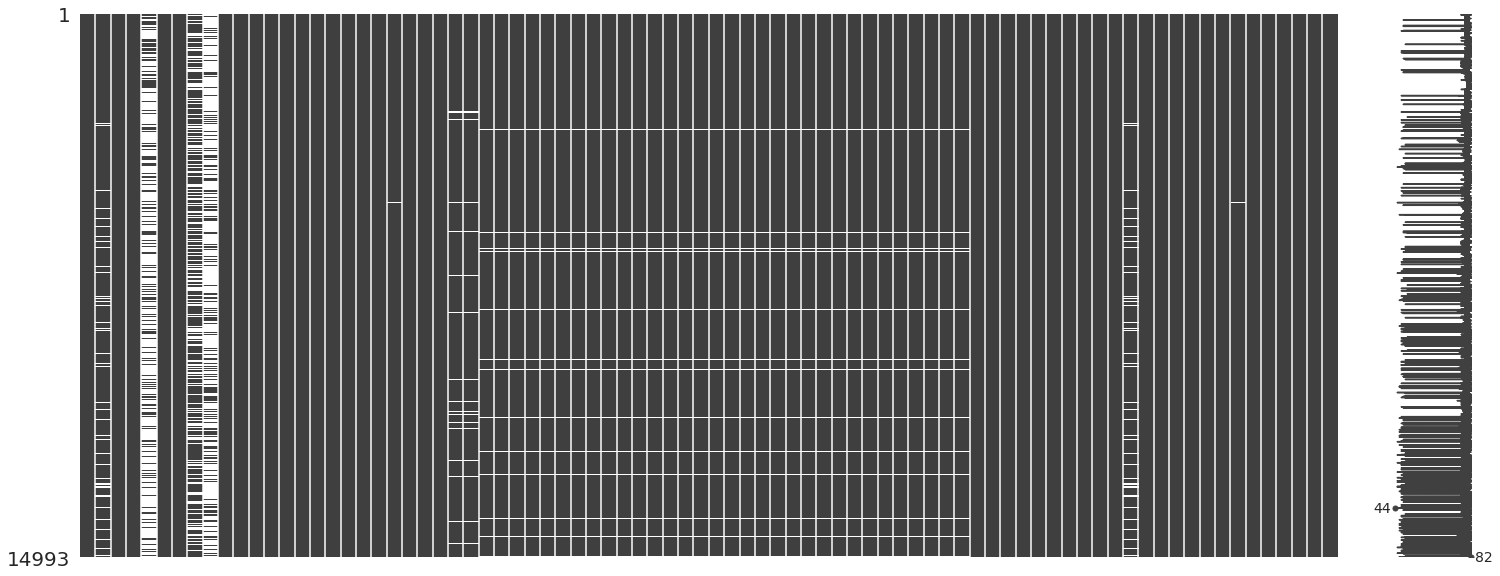

In [31]:
msno.matrix(train)

## **Numerical attributes and outliers**

#### **AdoptionSpeed**

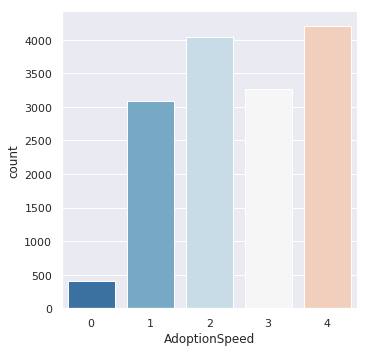

In [32]:
sns.catplot(x="AdoptionSpeed", kind="count", data=train)

Findings: 
* We have an unbalanced class, that could be a problem for some models.
* The probability of being adopted increases in the first month and then declines

#### **Age**

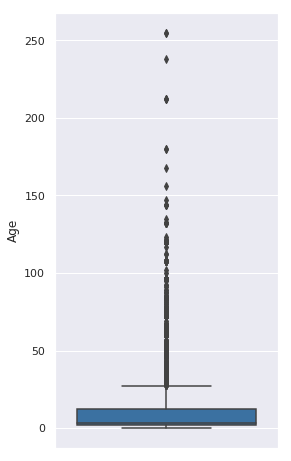

In [33]:
fig, ax = plt.subplots(figsize=(4,8))
sns.boxplot(y=train.Age)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


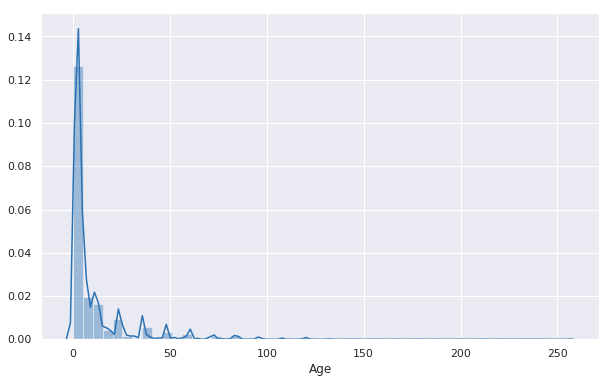

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(train.Age)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


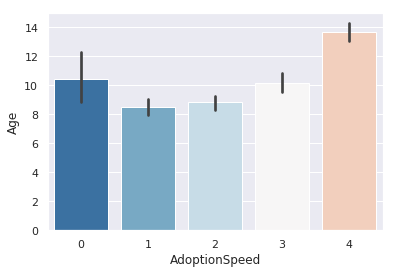

In [35]:
sns.barplot(x="AdoptionSpeed", y="Age", data=train)

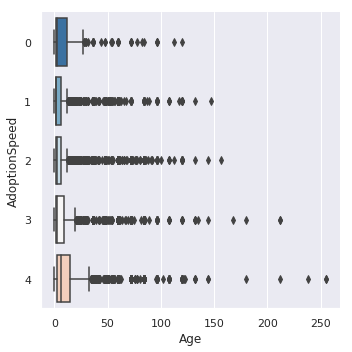

In [36]:
sns.catplot(y="AdoptionSpeed", x="Age", data=train, orient="h", kind="box")

Let's get a better visual look between age intervals and the adoption speed.
Based on our distribution we can divide our age in 4 categories: 0-1 year, 1-2 years, 2-4 years, 4-10 years and >10 years

In [37]:
train['AgeInterval'] = pd.Series(['0-3', '3-6', '6-12', '12-24', '24-48', '48-120', '>120'], dtype='category')
train.loc[(train['Age'] >= 0) & (train['Age'] <= 3),'AgeInterval'] = '0-3'
train.loc[(train['Age'] > 3) & (train['Age'] <= 6),'AgeInterval'] = '3-6'
train.loc[(train['Age'] > 6) & (train['Age'] <= 12),'AgeInterval'] = '6-12'
train.loc[(train['Age'] > 12) & (train['Age'] <= 24),'AgeInterval'] = '12-24'
train.loc[(train['Age'] > 24) & (train['Age'] <= 48),'AgeInterval'] = '24-48'
train.loc[(train['Age'] > 48) & (train['Age'] <= 120),'AgeInterval'] = '48-120'
train.loc[train['Age'] > 120,'AgeInterval'] = '>120'

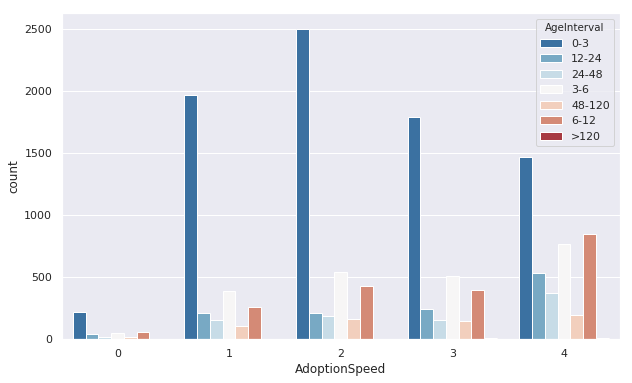

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x="AdoptionSpeed", hue="AgeInterval", data=train)

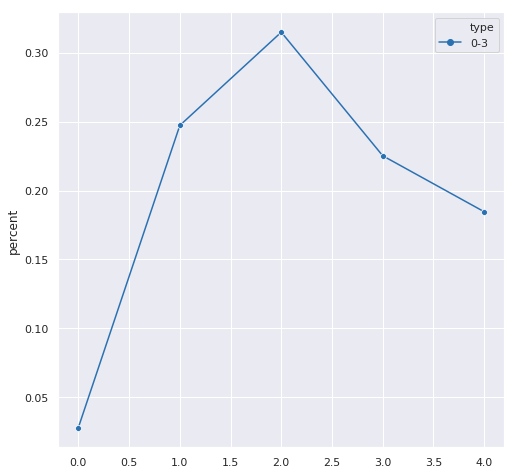

In [39]:
total = train[train.AgeInterval == '0-3'].size
interval1 = [
 train[(train.AdoptionSpeed == 0) & (train.AgeInterval == '0-3')].size,
 train[(train.AdoptionSpeed == 1) & (train.AgeInterval == '0-3')].size,
 train[(train.AdoptionSpeed == 2) & (train.AgeInterval == '0-3')].size,
 train[(train.AdoptionSpeed == 3) & (train.AgeInterval == '0-3')].size,
 train[(train.AdoptionSpeed == 4) & (train.AgeInterval == '0-3')].size
] / total

percents = np.append(interval1, [])
types = (['0-3'] * 5)

feePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 1, hue='type', style='type', markers=True, data=feePercentDf)

Findings:
* We have a lot of puppies in our dataset
* The mean age tends to grow on pets that are more time for adoption

#### **Quantity**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


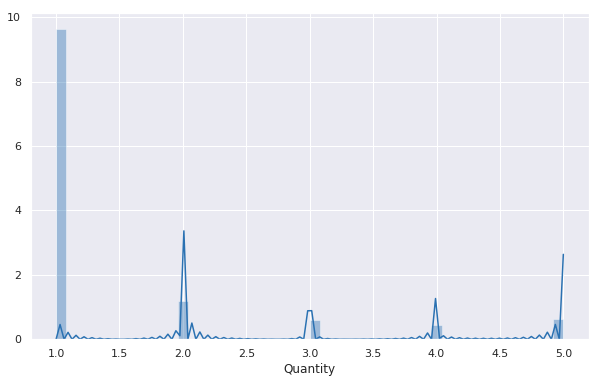

In [40]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(train.Quantity)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


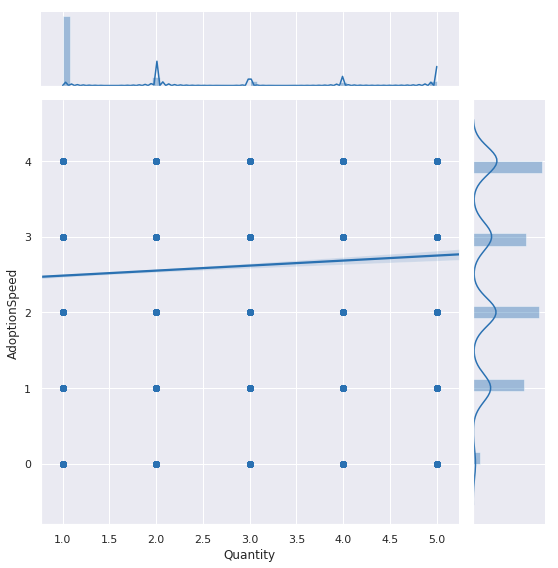

In [41]:
sns.jointplot(x="Quantity", y="AdoptionSpeed", data=train, kind="reg", height=8)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


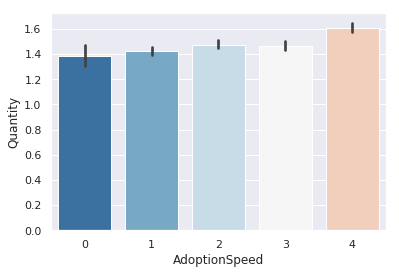

In [42]:
sns.barplot(x="AdoptionSpeed", y="Quantity", data=train)

Findings:
* Normally we have 1 pet per adoption
* We can see that the mean of quantity for adoption increases for later adoptions and non adopted

#### **VideoAmt**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


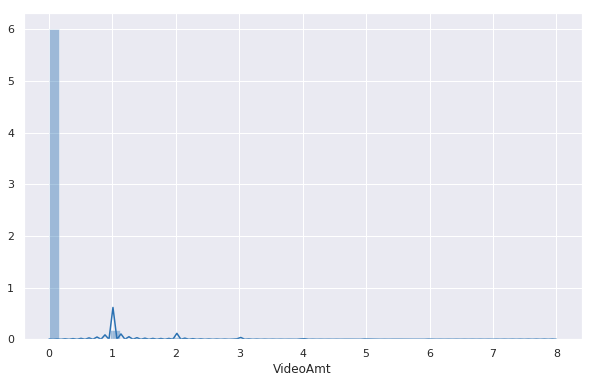

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(train.VideoAmt)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


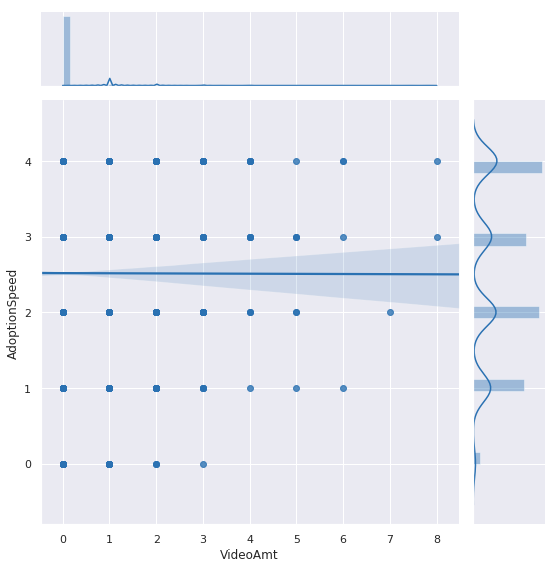

In [44]:
sns.jointplot(x="VideoAmt", y="AdoptionSpeed", data=train, kind="reg", height=8)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


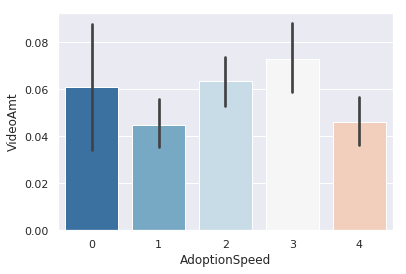

In [45]:
sns.barplot(x="AdoptionSpeed", y="VideoAmt", data=train)

Findings: The amount of videos doesn't seem to have much impact in AdoptionSpeed

#### **PhotoAmt**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


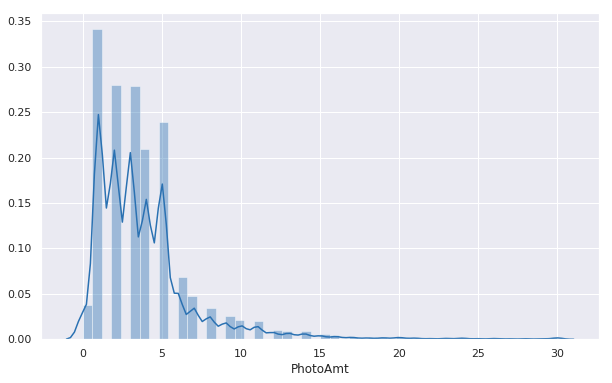

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(train.PhotoAmt)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


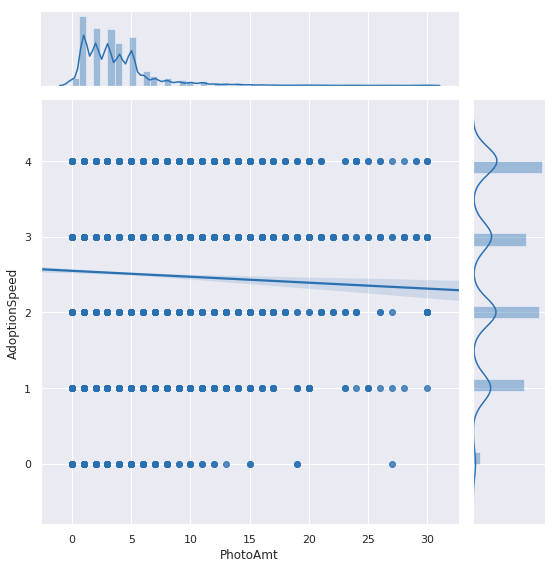

In [47]:
sns.jointplot(x="PhotoAmt", y="AdoptionSpeed", data=train, kind="reg", height=8)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


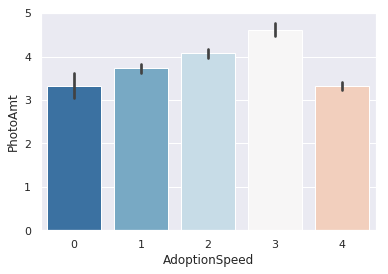

In [48]:
sns.barplot(x="AdoptionSpeed", y="PhotoAmt", data=train)

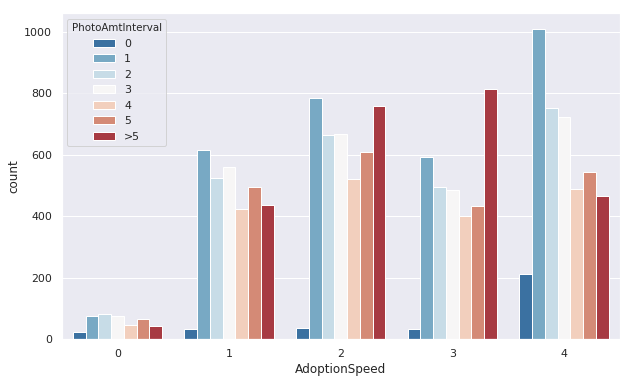

In [49]:
train['PhotoAmtInterval'] = pd.Series(['0', '1', '2', '3', '4', '5', '>5'], dtype='category')
train.loc[train['PhotoAmt'] == 0 ,'PhotoAmtInterval'] = '0'
train.loc[train['PhotoAmt'] == 1 ,'PhotoAmtInterval'] = '1'
train.loc[train['PhotoAmt'] == 2 ,'PhotoAmtInterval'] = '2'
train.loc[train['PhotoAmt'] == 3 ,'PhotoAmtInterval'] = '3'
train.loc[train['PhotoAmt'] == 4 ,'PhotoAmtInterval'] = '4'
train.loc[train['PhotoAmt'] == 5 ,'PhotoAmtInterval'] = '5'
train.loc[train['PhotoAmt'] > 5 ,'PhotoAmtInterval'] = '>5'

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x='AdoptionSpeed', hue='PhotoAmtInterval', data=train)

Findings:
* The majority of pets that have no pictures are on AdoptionSpeed 4
* It seems that putting 1-3 pictures it's relevant for getting adopted, more than that not so much.
* I assume from the >5 trend that people tend to add more picture when non-adopted time increases but after a certain threshold that trend stops.

#### **Fee**

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


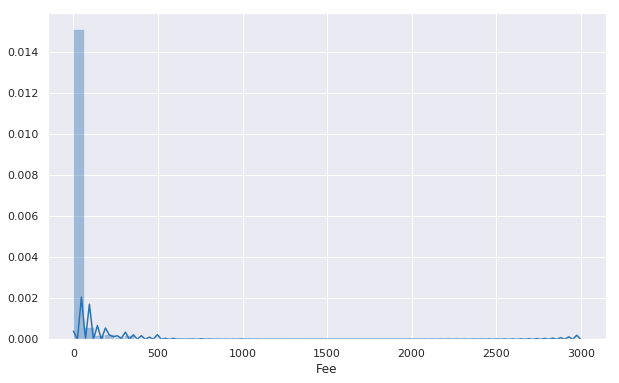

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(train.Fee)

**We clearly have some outliers here on Fee, let's remove them**

In [51]:
train = train[train.Fee <= 1500]

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


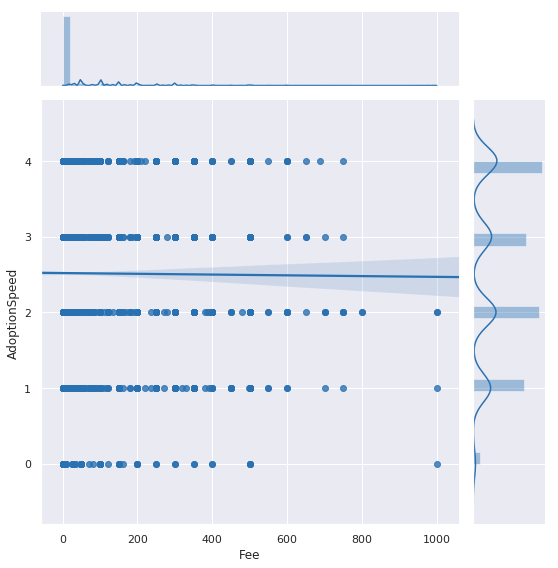

In [52]:
sns.jointplot(x='Fee', y='AdoptionSpeed', data=train, kind='reg', height=8)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


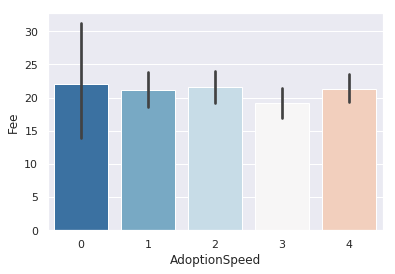

In [53]:
sns.barplot(x='AdoptionSpeed', y='Fee', data=train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


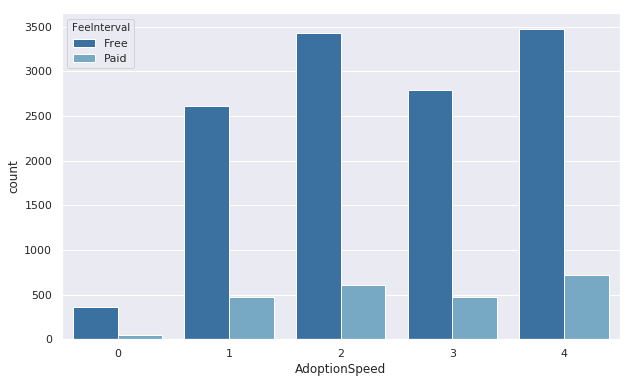

In [54]:
train['FeeInterval'] = pd.Series(['Free', 'Paid'], dtype='category')
train.loc[train['Fee'] == 0 ,'FeeInterval'] = 'Free'
train.loc[train['Fee'] > 0 ,'FeeInterval'] = 'Paid'

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x='AdoptionSpeed', hue='FeeInterval', data=train)

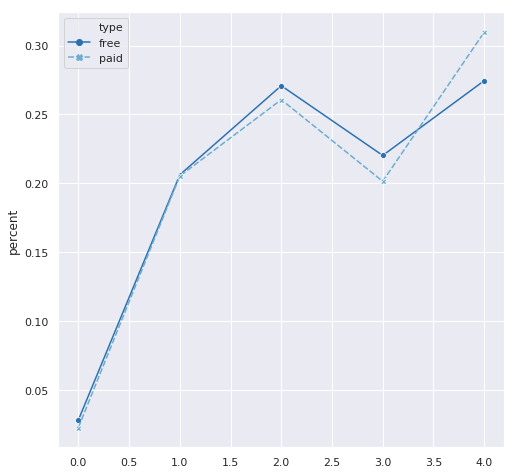

In [55]:
total = train[train.Fee == 0].size
feeFreePercent = [
 train[(train.AdoptionSpeed == 0) & (train.Fee == 0)].size,
 train[(train.AdoptionSpeed == 1) & (train.Fee == 0)].size,
 train[(train.AdoptionSpeed == 2) & (train.Fee == 0)].size,
 train[(train.AdoptionSpeed == 3) & (train.Fee == 0)].size,
 train[(train.AdoptionSpeed == 4) & (train.Fee == 0)].size
] / total

total = train[train.Fee > 0].size
feePaidPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Fee > 0)].size,
 train[(train.AdoptionSpeed == 1) & (train.Fee > 0)].size,
 train[(train.AdoptionSpeed == 2) & (train.Fee > 0)].size,
 train[(train.AdoptionSpeed == 3) & (train.Fee > 0)].size,
 train[(train.AdoptionSpeed == 4) & (train.Fee > 0)].size
] / total

percents = np.append(feeFreePercent, feePaidPercent)
types = (['free'] * 5) + (['paid'] * 5)

feePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 2, hue='type', style='type', markers=True, data=feePercentDf)

Findings: 
* Proportionally we have more `paid` pets on non adopt class.
* We can conclude that charging for a fee can increases your changes of not being adopted.

## **Categorical attributes and outliers**

#### **Type**

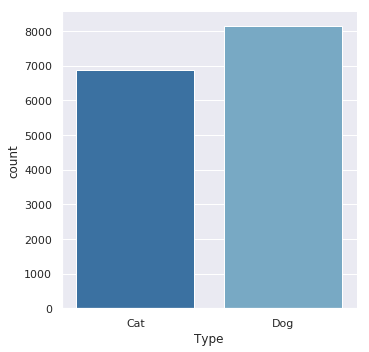

In [56]:
# 1 = Dog, 2 = Cat
sns.catplot(x="Type", kind="count", data=train)

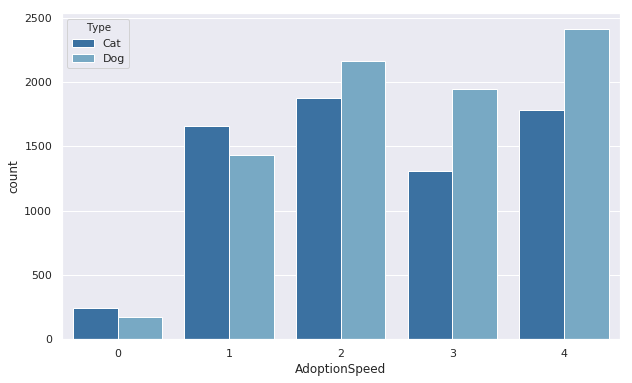

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x='AdoptionSpeed', hue='Type', data=train)

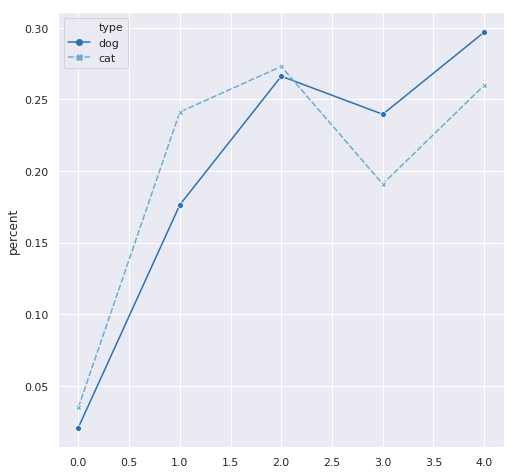

In [58]:
total = train[train.Type == 'Dog'].size
dogPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Type == 'Dog')].size,
 train[(train.AdoptionSpeed == 1) & (train.Type == 'Dog')].size,
 train[(train.AdoptionSpeed == 2) & (train.Type == 'Dog')].size,
 train[(train.AdoptionSpeed == 3) & (train.Type == 'Dog')].size,
 train[(train.AdoptionSpeed == 4) & (train.Type == 'Dog')].size
] / total

total = train[train.Type == 'Cat'].size
catPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Type == 'Cat')].size,
 train[(train.AdoptionSpeed == 1) & (train.Type == 'Cat')].size,
 train[(train.AdoptionSpeed == 2) & (train.Type == 'Cat')].size,
 train[(train.AdoptionSpeed == 3) & (train.Type == 'Cat')].size,
 train[(train.AdoptionSpeed == 4) & (train.Type == 'Cat')].size
] / total

percents = np.append(dogPercent, catPercent)
types = (['dog'] * 5) + (['cat'] * 5)

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 2, hue='type', style='type', markers=True, data=typePercentDf)

Findings:
* Cats seems to have a higher adoption speed than dogs.
* Both follow the same trend. Up trend on first month and then the probability of being adopted drops.
* The probability of non adoption seems to be higher for dogs

#### **Breed**

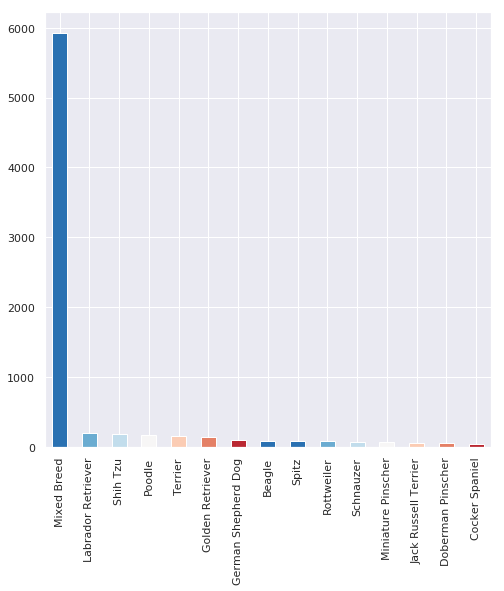

In [59]:
dogCounts = train[train.Type == 'Dog'].Breed1.value_counts()
fig, ax = plt.subplots(figsize=(8,8))
dogCounts.nlargest(15).plot(kind='bar')

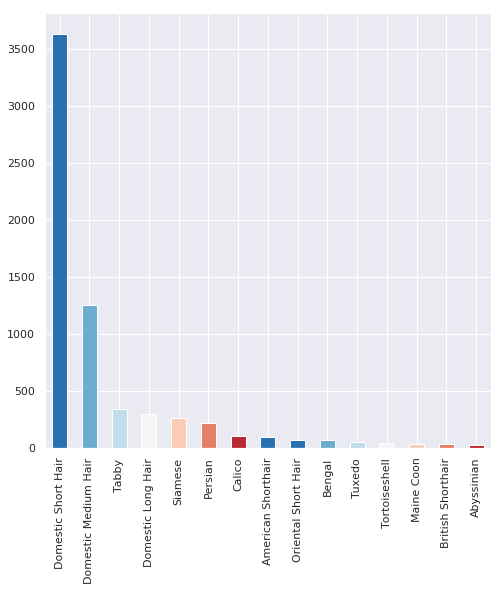

In [60]:
catCounts = train[train.Type == 'Cat'].Breed1.value_counts()
fig, ax = plt.subplots(figsize=(8,8))
catCounts.nlargest(15).plot(kind='bar')

In [61]:
strayCat = ['Domestic Short Hair', 'Domestic Medium Hair', 'Domestic Long Hair']
strayDog = ['Mixed Breed']

train.loc[(train.Breed1.isin(strayDog)) & (train.Type == 'Dog'), 'Breed1Type'] = 'Stray'
train.loc[(train.Breed1.isin(strayCat)) & (train.Type == 'Cat'), 'Breed1Type'] = 'Stray'
train.loc[(~train.Breed1.isin(strayDog)) & (train.Type == 'Dog'), 'Breed1Type'] = 'Breed'
train.loc[(~train.Breed1.isin(strayCat)) & (train.Type == 'Cat'), 'Breed1Type'] = 'Breed'

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


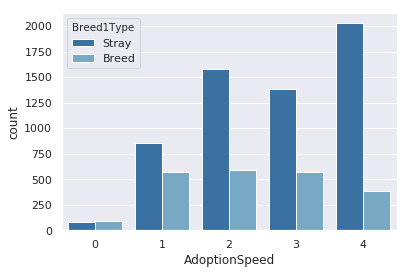

In [62]:
sns.countplot(x='AdoptionSpeed', hue='Breed1Type', data=train[train.Type == 'Dog'])

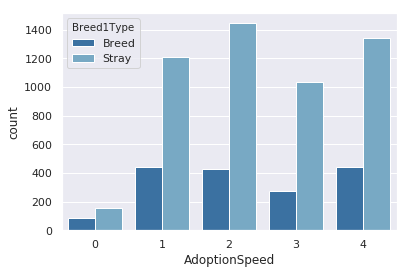

In [63]:
sns.countplot(x='AdoptionSpeed', hue='Breed1Type', data=train[train.Type == 'Cat'])

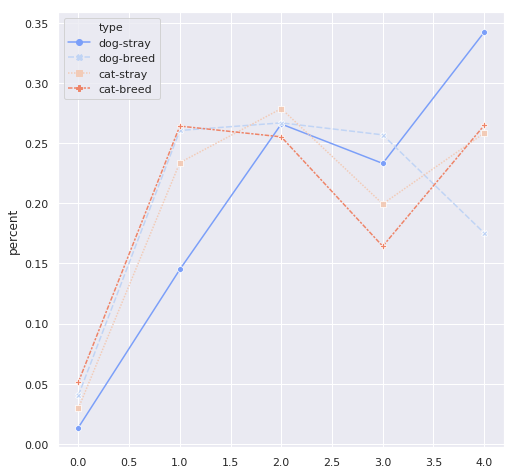

In [64]:
total = train[(train.Type == 'Dog') & (train.Breed1Type == 'Stray')].size
dogPercentStray = [
 train[(train.AdoptionSpeed == 0) & (train.Type == 'Dog') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 1) & (train.Type == 'Dog') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 2) & (train.Type == 'Dog') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 3) & (train.Type == 'Dog') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 4) & (train.Type == 'Dog') & (train.Breed1Type == 'Stray')].size
] / total

total = train[(train.Type == 'Dog') & (train.Breed1Type == 'Breed')].size
dogPercentBreed = [
 train[(train.AdoptionSpeed == 0) & (train.Type == 'Dog') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 1) & (train.Type == 'Dog') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 2) & (train.Type == 'Dog') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 3) & (train.Type == 'Dog') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 4) & (train.Type == 'Dog') & (train.Breed1Type == 'Breed')].size
] / total

total = train[(train.Type == 'Cat') & (train.Breed1Type == 'Stray')].size
catPercentStray = [
 train[(train.AdoptionSpeed == 0) & (train.Type == 'Cat') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 1) & (train.Type == 'Cat') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 2) & (train.Type == 'Cat') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 3) & (train.Type == 'Cat') & (train.Breed1Type == 'Stray')].size,
 train[(train.AdoptionSpeed == 4) & (train.Type == 'Cat') & (train.Breed1Type == 'Stray')].size
] / total

total = train[(train.Type == 'Cat') & (train.Breed1Type == 'Breed')].size
catPercentBreed = [
 train[(train.AdoptionSpeed == 0) & (train.Type == 'Cat') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 1) & (train.Type == 'Cat') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 2) & (train.Type == 'Cat') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 3) & (train.Type == 'Cat') & (train.Breed1Type == 'Breed')].size,
 train[(train.AdoptionSpeed == 4) & (train.Type == 'Cat') & (train.Breed1Type == 'Breed')].size
] / total

percents = np.append(dogPercentStray, dogPercentBreed)
percents = np.append(percents, catPercentStray)
percents = np.append(percents, catPercentBreed)
types = (['dog-stray'] * 5 + ['dog-breed'] * 5 + ['cat-stray'] * 5 + ['cat-breed'] * 5)

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 4, hue='type', style='type', markers=True, data=typePercentDf, palette='coolwarm')

Findings:
* We have more stray dogs than cats proporcionally
* Stray dogs have a greater likelihood to not be adopted
* Stray cats are adopted at the same rate as with breed. People don't care much about breeds of cats appearently.

#### **Color**

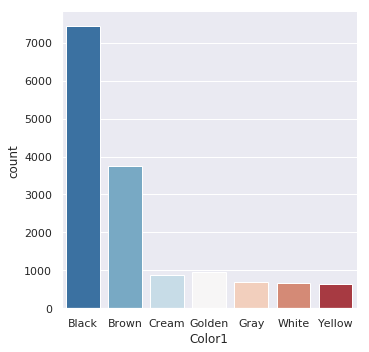

In [65]:
sns.catplot(x='Color1', kind='count', data=train)

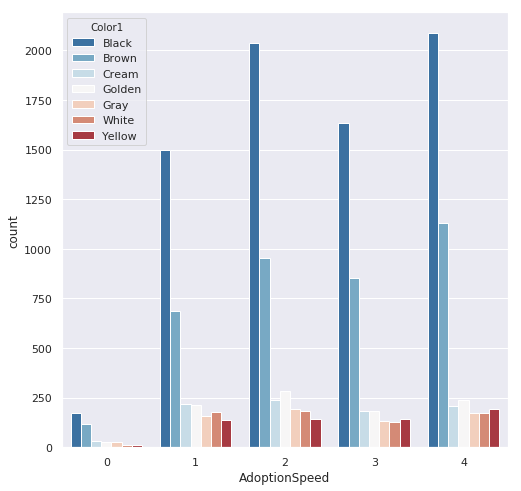

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='AdoptionSpeed', hue='Color1', data=train)

Findings: clearly color doesn't have much effect on AdoptionSpeed. It follows always the same proportional in all classes

#### **MaturitySize**

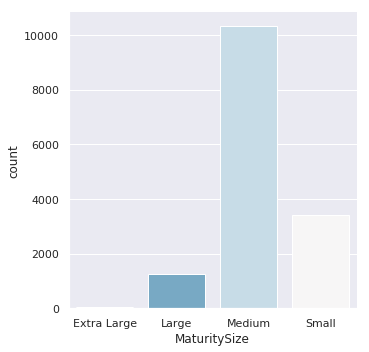

In [67]:
sns.catplot(x='MaturitySize', kind='count', data=train)

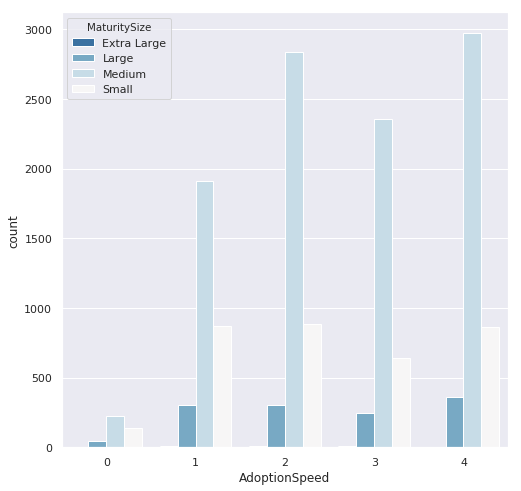

In [68]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='AdoptionSpeed', hue='MaturitySize', data=train)

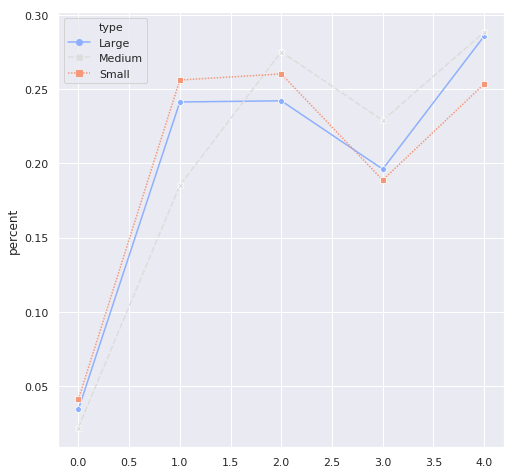

In [69]:
total = train[(train.MaturitySize == 'Large')].size
largePercent = [
 train[(train.AdoptionSpeed == 0) & (train.MaturitySize == 'Large')].size,
 train[(train.AdoptionSpeed == 1) & (train.MaturitySize == 'Large')].size,
 train[(train.AdoptionSpeed == 2) & (train.MaturitySize == 'Large')].size,
 train[(train.AdoptionSpeed == 3) & (train.MaturitySize == 'Large')].size,
 train[(train.AdoptionSpeed == 4) & (train.MaturitySize == 'Large')].size
] / total

total = train[(train.MaturitySize == 'Medium')].size
mediumPercent = [
 train[(train.AdoptionSpeed == 0) & (train.MaturitySize == 'Medium')].size,
 train[(train.AdoptionSpeed == 1) & (train.MaturitySize == 'Medium')].size,
 train[(train.AdoptionSpeed == 2) & (train.MaturitySize == 'Medium')].size,
 train[(train.AdoptionSpeed == 3) & (train.MaturitySize == 'Medium')].size,
 train[(train.AdoptionSpeed == 4) & (train.MaturitySize == 'Medium')].size
] / total

total = train[(train.MaturitySize == 'Small')].size
smallPercent = [
 train[(train.AdoptionSpeed == 0) & (train.MaturitySize == 'Small')].size,
 train[(train.AdoptionSpeed == 1) & (train.MaturitySize == 'Small')].size,
 train[(train.AdoptionSpeed == 2) & (train.MaturitySize == 'Small')].size,
 train[(train.AdoptionSpeed == 3) & (train.MaturitySize == 'Small')].size,
 train[(train.AdoptionSpeed == 4) & (train.MaturitySize == 'Small')].size
] / total

percents = np.append(largePercent, mediumPercent)
percents = np.append(percents, smallPercent)
types = (['Large'] * 5 + ['Medium'] * 5 + ['Small'] * 5 )

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 3, hue='type', style='type', markers=True, data=typePercentDf, palette='coolwarm')

Findings:
* We have a lot of Medium pets
* Large and Small are more likely to be adopted in the first week than Medium
* All follow the same trends
* Small has a greater change to be adopted

#### **FurLength**

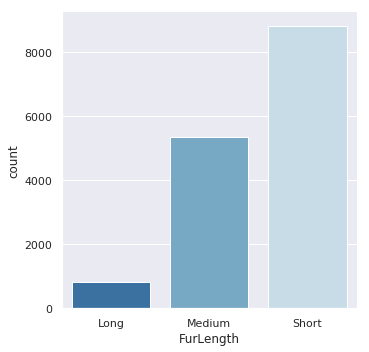

In [70]:
sns.catplot(x='FurLength', kind='count', data=train)

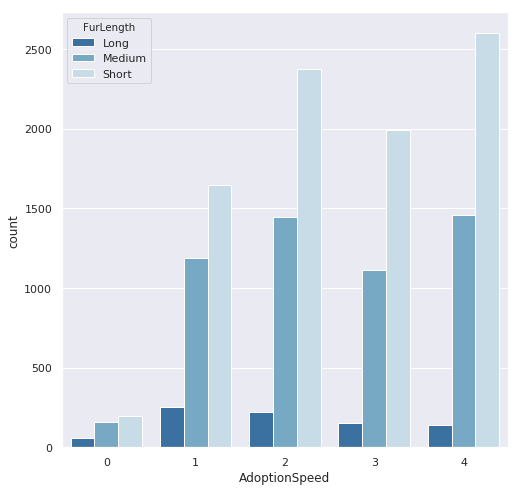

In [71]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='AdoptionSpeed', hue='FurLength', data=train)

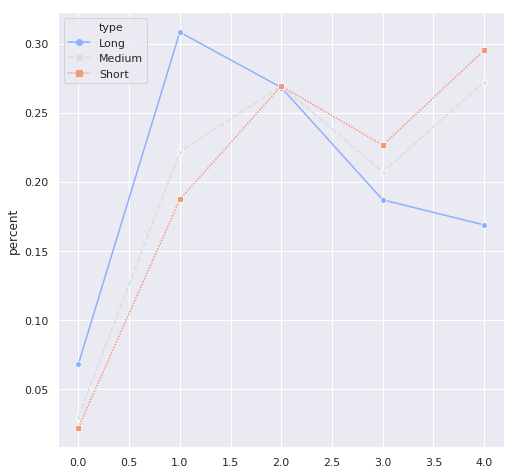

In [72]:
total = train[(train.FurLength == 'Long')].size
longPercent = [
 train[(train.AdoptionSpeed == 0) & (train.FurLength == 'Long')].size,
 train[(train.AdoptionSpeed == 1) & (train.FurLength == 'Long')].size,
 train[(train.AdoptionSpeed == 2) & (train.FurLength == 'Long')].size,
 train[(train.AdoptionSpeed == 3) & (train.FurLength == 'Long')].size,
 train[(train.AdoptionSpeed == 4) & (train.FurLength == 'Long')].size
] / total

total = train[(train.FurLength == 'Medium')].size
mediumPercent = [
 train[(train.AdoptionSpeed == 0) & (train.FurLength == 'Medium')].size,
 train[(train.AdoptionSpeed == 1) & (train.FurLength == 'Medium')].size,
 train[(train.AdoptionSpeed == 2) & (train.FurLength == 'Medium')].size,
 train[(train.AdoptionSpeed == 3) & (train.FurLength == 'Medium')].size,
 train[(train.AdoptionSpeed == 4) & (train.FurLength == 'Medium')].size
] / total

total = train[(train.FurLength == 'Short')].size
shortPercent = [
 train[(train.AdoptionSpeed == 0) & (train.FurLength == 'Short')].size,
 train[(train.AdoptionSpeed == 1) & (train.FurLength == 'Short')].size,
 train[(train.AdoptionSpeed == 2) & (train.FurLength == 'Short')].size,
 train[(train.AdoptionSpeed == 3) & (train.FurLength == 'Short')].size,
 train[(train.AdoptionSpeed == 4) & (train.FurLength == 'Short')].size
] / total

percents = np.append(longPercent, mediumPercent)
percents = np.append(percents, shortPercent)
types = (['Long'] * 5 + ['Medium'] * 5 + ['Short'] * 5 )

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 3, hue='type', style='type', markers=True, data=typePercentDf, palette='coolwarm')

Findings:
* Long fur have a high adoption rate in the first week and the lowest probability of not being adopted after 100 days
* Short fur have the highest probability of not being adopted after 100 days
* My conclusion is that pets with long furs tend to appear more cute and that has a huge impact in a decision to adopt or not.

#### **Vaccinated**

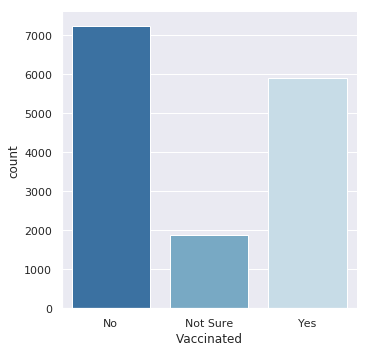

In [73]:
sns.catplot(x='Vaccinated', kind='count', data=train)

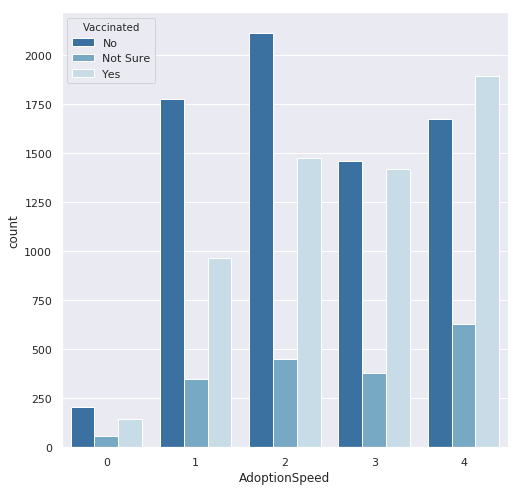

In [74]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='AdoptionSpeed', hue='Vaccinated', data=train)

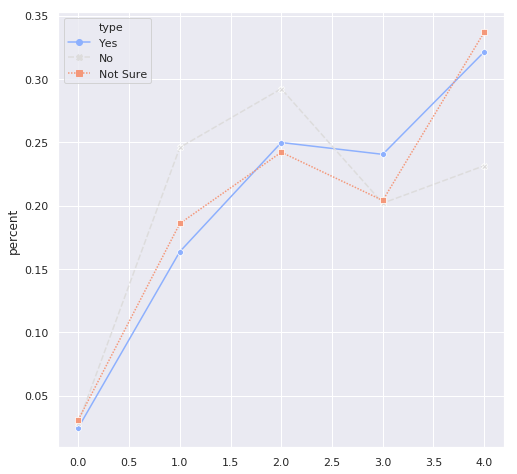

In [75]:
total = train[(train.Vaccinated == 'Yes')].size
yesPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Vaccinated == 'Yes')].size,
 train[(train.AdoptionSpeed == 1) & (train.Vaccinated == 'Yes')].size,
 train[(train.AdoptionSpeed == 2) & (train.Vaccinated == 'Yes')].size,
 train[(train.AdoptionSpeed == 3) & (train.Vaccinated == 'Yes')].size,
 train[(train.AdoptionSpeed == 4) & (train.Vaccinated == 'Yes')].size
] / total

total = train[(train.Vaccinated == 'No')].size
noPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Vaccinated == 'No')].size,
 train[(train.AdoptionSpeed == 1) & (train.Vaccinated == 'No')].size,
 train[(train.AdoptionSpeed == 2) & (train.Vaccinated == 'No')].size,
 train[(train.AdoptionSpeed == 3) & (train.Vaccinated == 'No')].size,
 train[(train.AdoptionSpeed == 4) & (train.Vaccinated == 'No')].size
] / total

total = train[(train.Vaccinated == 'Not Sure')].size
notSurePercent = [
 train[(train.AdoptionSpeed == 0) & (train.Vaccinated == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 1) & (train.Vaccinated == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 2) & (train.Vaccinated == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 3) & (train.Vaccinated == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 4) & (train.Vaccinated == 'Not Sure')].size
] / total

percents = np.append(yesPercent, noPercent)
percents = np.append(percents, notSurePercent)
types = (['Yes'] * 5 + ['No'] * 5 + ['Not Sure'] * 5 )

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 3, hue='type', style='type', markers=True, data=typePercentDf, palette='coolwarm')

Findings: Being Vaccinated doesn't seem to be relevant to be adopted or not. Appearently if the adopter likes the pet for other features that end up being irrelevant.

#### **Dewormed**

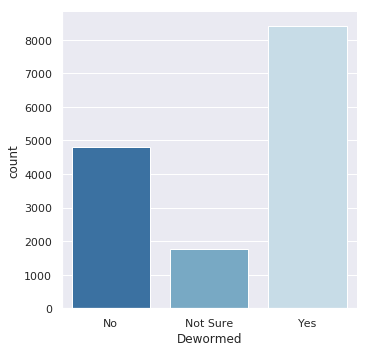

In [76]:
sns.catplot(x='Dewormed', kind='count', data=train)

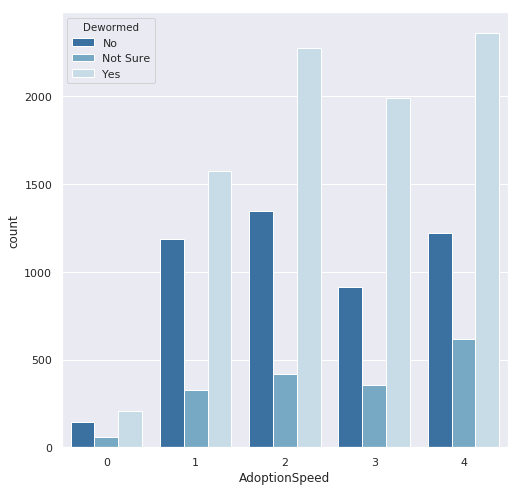

In [77]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='AdoptionSpeed', hue='Dewormed', data=train)

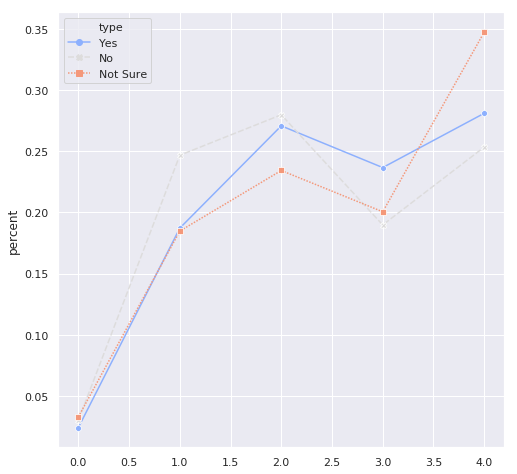

In [78]:
total = train[(train.Dewormed == 'Yes')].size
yesPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Dewormed == 'Yes')].size,
 train[(train.AdoptionSpeed == 1) & (train.Dewormed == 'Yes')].size,
 train[(train.AdoptionSpeed == 2) & (train.Dewormed == 'Yes')].size,
 train[(train.AdoptionSpeed == 3) & (train.Dewormed == 'Yes')].size,
 train[(train.AdoptionSpeed == 4) & (train.Dewormed == 'Yes')].size
] / total

total = train[(train.Dewormed == 'No')].size
noPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Dewormed == 'No')].size,
 train[(train.AdoptionSpeed == 1) & (train.Dewormed == 'No')].size,
 train[(train.AdoptionSpeed == 2) & (train.Dewormed == 'No')].size,
 train[(train.AdoptionSpeed == 3) & (train.Dewormed == 'No')].size,
 train[(train.AdoptionSpeed == 4) & (train.Dewormed == 'No')].size
] / total

total = train[(train.Dewormed == 'Not Sure')].size
notSurePercent = [
 train[(train.AdoptionSpeed == 0) & (train.Dewormed == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 1) & (train.Dewormed == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 2) & (train.Dewormed == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 3) & (train.Dewormed == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 4) & (train.Dewormed == 'Not Sure')].size
] / total

percents = np.append(yesPercent, noPercent)
percents = np.append(percents, notSurePercent)
types = (['Yes'] * 5 + ['No'] * 5 + ['Not Sure'] * 5 )

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 3, hue='type', style='type', markers=True, data=typePercentDf, palette='coolwarm')

Findings: Dewormed seems to have the same impact as Vaccinated. I assume that other features define the decision of the adopter and vaccinate and deworm it's just something it's not really a deal breaker.

#### **Sterilized**

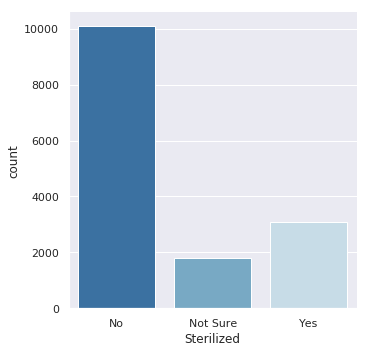

In [79]:
sns.catplot(x='Sterilized', kind='count', data=train)

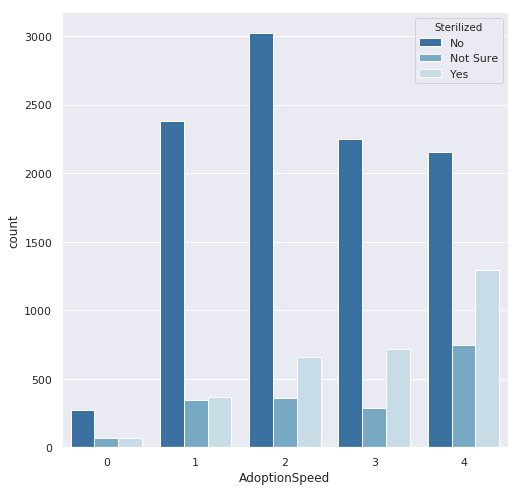

In [80]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='AdoptionSpeed', hue='Sterilized', data=train)

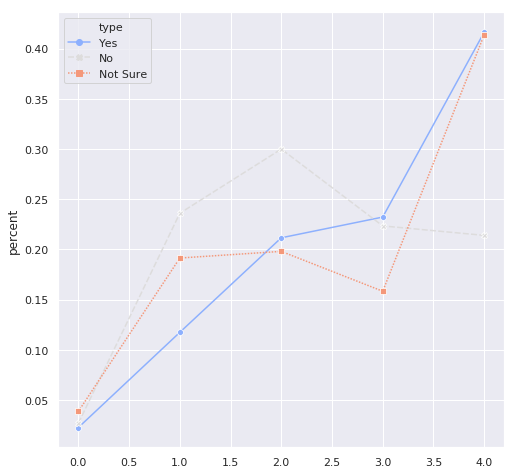

In [81]:
total = train[(train.Sterilized == 'Yes')].size
yesPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Sterilized == 'Yes')].size,
 train[(train.AdoptionSpeed == 1) & (train.Sterilized == 'Yes')].size,
 train[(train.AdoptionSpeed == 2) & (train.Sterilized == 'Yes')].size,
 train[(train.AdoptionSpeed == 3) & (train.Sterilized == 'Yes')].size,
 train[(train.AdoptionSpeed == 4) & (train.Sterilized == 'Yes')].size
] / total

total = train[(train.Sterilized == 'No')].size
noPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Sterilized == 'No')].size,
 train[(train.AdoptionSpeed == 1) & (train.Sterilized == 'No')].size,
 train[(train.AdoptionSpeed == 2) & (train.Sterilized == 'No')].size,
 train[(train.AdoptionSpeed == 3) & (train.Sterilized == 'No')].size,
 train[(train.AdoptionSpeed == 4) & (train.Sterilized == 'No')].size
] / total

total = train[(train.Sterilized == 'Not Sure')].size
notSurePercent = [
 train[(train.AdoptionSpeed == 0) & (train.Sterilized == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 1) & (train.Sterilized == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 2) & (train.Sterilized == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 3) & (train.Sterilized == 'Not Sure')].size,
 train[(train.AdoptionSpeed == 4) & (train.Sterilized == 'Not Sure')].size
] / total

percents = np.append(yesPercent, noPercent)
percents = np.append(percents, notSurePercent)
types = (['Yes'] * 5 + ['No'] * 5 + ['Not Sure'] * 5 )

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 3, hue='type', style='type', markers=True, data=typePercentDf, palette='coolwarm')

Findings: Being Sterilizzed doesn't seem to have impact in being adopted.

#### **Health**

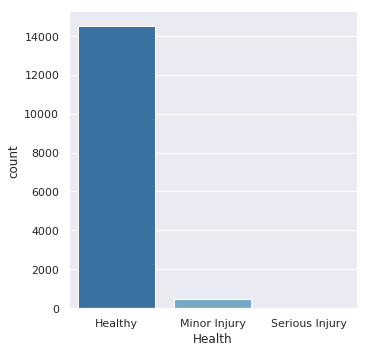

In [82]:
sns.catplot(x='Health', kind='count', data=train)

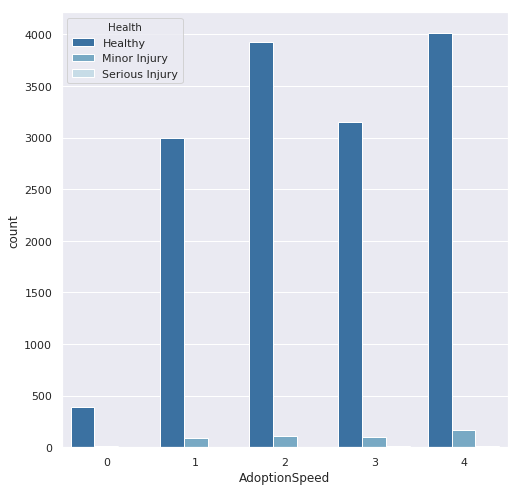

In [83]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x='AdoptionSpeed', hue='Health', data=train)

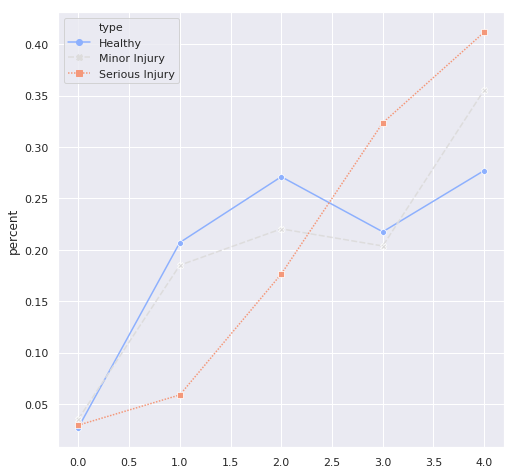

In [84]:
total = train[(train.Health == 'Healthy')].size
healthyPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Health == 'Healthy')].size,
 train[(train.AdoptionSpeed == 1) & (train.Health == 'Healthy')].size,
 train[(train.AdoptionSpeed == 2) & (train.Health == 'Healthy')].size,
 train[(train.AdoptionSpeed == 3) & (train.Health == 'Healthy')].size,
 train[(train.AdoptionSpeed == 4) & (train.Health == 'Healthy')].size
] / total

total = train[(train.Health == 'Minor Injury')].size
minorPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Health == 'Minor Injury')].size,
 train[(train.AdoptionSpeed == 1) & (train.Health == 'Minor Injury')].size,
 train[(train.AdoptionSpeed == 2) & (train.Health == 'Minor Injury')].size,
 train[(train.AdoptionSpeed == 3) & (train.Health == 'Minor Injury')].size,
 train[(train.AdoptionSpeed == 4) & (train.Health == 'Minor Injury')].size
] / total

total = train[(train.Health == 'Serious Injury')].size
seriousPercent = [
 train[(train.AdoptionSpeed == 0) & (train.Health == 'Serious Injury')].size,
 train[(train.AdoptionSpeed == 1) & (train.Health == 'Serious Injury')].size,
 train[(train.AdoptionSpeed == 2) & (train.Health == 'Serious Injury')].size,
 train[(train.AdoptionSpeed == 3) & (train.Health == 'Serious Injury')].size,
 train[(train.AdoptionSpeed == 4) & (train.Health == 'Serious Injury')].size
] / total

percents = np.append(healthyPercent, minorPercent)
percents = np.append(percents, seriousPercent)
types = (['Healthy'] * 5 + ['Minor Injury'] * 5 + ['Serious Injury'] * 5 )

typePercentDf = pd.DataFrame({ 'percent': percents, 'type': types })

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(y='percent', x=[0, 1, 2, 3, 4] * 3, hue='type', style='type', markers=True, data=typePercentDf, palette='coolwarm')

Findings:
* Being healthy has a lower probability of not being adopted after 100 days
* The more serious the injuries higher are the chances of not being adopted after 100 days

## **Classification**

### **Catboost**

In [85]:
target = 'AdoptionSpeed'
# categoricalFeatures = list(set(categoricalFeatures) - set([target, 'State', 'RescuerID', 'PetID', 'Color2', 'Color3', 'Breed2']))
#numericalFeatures = ['Age', 'Quantity', 'Fee', 'PhotoAmt', 'VideoAmt']
# catFeaturesIndex = list(range(0, len(categoricalFeatures)))

# cateogrical features to train
categorical = ['Type', 'Breed1', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'State']

features = categorical + numericalFeatures
data = train[features + [target]].dropna()

# X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.25, random_state=42)

In [86]:
# train_data = FeaturesData(
#     num_feature_data=X_train[numericalFeatures].astype('float32').values,
#     cat_feature_data=X_train[categoricalFeatures].__array__(dtype=object)
# )

# train_labels = y_train.astype('int').values

# clf = CatBoostClassifier(loss_function='MultiClass', verbose=True, depth=10, iterations= 100, l2_leaf_reg= 9, learning_rate= 0.15)
# clf.fit(train_data, train_labels)

**Confusion Matrix to compare predictions per class**

In [87]:
# test_data = FeaturesData(
#     num_feature_data=X_test[numericalFeatures].astype('float32').values,
#     cat_feature_data=X_test[categoricalFeatures].__array__(dtype=object)
# )

# test_labels = y_test.astype('int').values
# y_predicted = clf.predict(test_data)

def generateConfusionMatrix(y_real, y_predicted):
    cm = pd.DataFrame()
    cm['Satisfaction'] = y_real
    cm['Predict'] = y_predicted
    mappingSatisfaction = {0:'Same Day', 1: 'First Week', 2: 'First Month', 3: '2-3 Month', 4: 'Non-Adopted >100'}
    mappingPredict = {0.0:'Same Day', 1.0: 'First Week', 2.0: 'First Month', 3.0: '2-3 Month', 4.0: 'Non-Adopted >100'}
    cm = cm.replace({'Satisfaction': mappingSatisfaction, 'Predict': mappingPredict})
    return pd.crosstab(cm['Satisfaction'], cm['Predict'], margins=True)

# generateConfusionMatrix(y_test, y_predicted)

**Model score on test data split**

In [88]:
# clf.score(test_data, test_labels)

**Check most relevant features**

In [89]:
def plotMostRelevantFeatures(indexes, model, train_data, train_labels, title='Feature Importance Ranking'):
    feature_score = pd.DataFrame(list(zip(indexes, model.get_feature_importance(Pool(train_data, label=train_labels)))),
                columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    # get feature score as labels round to 2 decimal
    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

# plotMostRelevantFeatures(X_train.dtypes.index, clf, train_data, train_labels)

**Submission**

In [90]:
# bestCatFeatures = ['Sterilized', 'Breed1', 'Type', 'MaturitySize', 'FurLength', 'Gender', 'Health', 'Color1', 'Fee', 'Vaccinated']
# bestNumFeatures = ['Age', 'Quantity', 'PhotoAmt']

# train_data = FeaturesData(
#     num_feature_data=X_train[bestNumFeatures].astype('float32').values,
#     cat_feature_data=X_train[bestCatFeatures].__array__(dtype=object)
# )

# train_labels = y_train.astype('int').values

# clf = CatBoostClassifier(loss_function='MultiClass', verbose=False, depth=10, iterations= 100, l2_leaf_reg= 9, learning_rate= 0.15)
# clf.fit(data[mostImportantFeatures], data[target], cat_features= mostImportantCatIndex, plot=False)
# predictions = clf.predict(test[mostImportantFeatures])
# predictions

In [91]:
# test['AdoptionSpeed'] = predictions
# test.AdoptionSpeed = test['AdoptionSpeed'].map({0.0: '0', 1.0: '1', 2.0: '2', 3.0: '3', 4.0: '4'})
# test[['PetID', 'AdoptionSpeed']].to_csv('submission.csv', index=False)

In [92]:
def calculateClassificationScores(y_true, y_predicted, model, X_test, average='macro'):
    accuracy = accuracy_score(y_true, y_predicted)
    f1 = f1_score(y_true, y_predicted, average=average)
    precision = precision_score(y_true, y_predicted, average=average)
    recall = recall_score(y_true, y_predicted, average=average)
    if model and isinstance(model, CatBoostClassifier):
        score = model.get_best_score()
        if score.get('validation_0'):
            multiclass = score['validation_0']['MultiClass']
        else:
            multiclass = model.score(X_test, y_true)
        return (accuracy, f1, precision, recall, multiclass)
    
    return (accuracy, f1, precision, recall)

def crossValidation(params, X, y):
    f1_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    multiclass_scores = []

    for train_index, val_index in skf.split(X.values, y.values):
        
        X_train = X[X.index.isin(train_index)]
        X_train = FeaturesData(
            num_feature_data=X_train[numericalFeatures].astype('float32').values,
            cat_feature_data=X_train[categoricalFeatures].__array__(dtype=object)
        )
        y_train = y[y.index.isin(train_index)].astype('int').values
        
        X_valid = X[X.index.isin(val_index)]
        X_valid = FeaturesData(
            num_feature_data=X_valid[numericalFeatures].astype('float32').values,
            cat_feature_data=X_valid[categoricalFeatures].__array__(dtype=object)
        )
        y_valid = y[y.index.isin(val_index)].astype('int').values
        
        pool_test = Pool(X_valid, label=y_valid)
        
        clf = CatBoostClassifier(
            loss_function='MultiClass',
            verbose=False,
            depth=params['depth'],
            iterations=params['iterations'],
            l2_leaf_reg=params['l2_leaf_reg'],
            learning_rate=params['learning_rate'],
            task_type='CPU'
        )
        
        clf.fit(X_train, y_train, eval_set=pool_test, use_best_model=True)
        
        y_pred = clf.predict(X_valid)
        
        # calculateClassificationScores(y_test, y_predicted, clfSentiment, X_test_pool)
        
        (accuracy, f1, precision, recall, multiclass) = calculateClassificationScores(y_valid, y_pred, clf, X_valid)
        
        multiclass_scores.append(multiclass)
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        
    return (multiclass_scores, accuracy_scores, f1_scores, precision_scores, recall_scores)
    

def searchBestParams(grid, X, y):
    catboostDf = pd.DataFrame({
        'model':[],
        'multiclass_score_mean':[],
        'multiclass_score_std':[],
        'f1_score_mean':[],
        'f1_score_std':[],
        'accuracy_score_mean':[],
        'accuracy_score_std':[],
        'precision_score_mean':[],
        'precision_score_std':[],
        'recall_score_mean':[],
        'recall_score_std':[],
        'params': []}
    )
    for params in grid:
        print(params)
        (multiclass_scores, accuracy_scores, f1_scores, precision_scores, recall_scores) = crossValidation(params, X, y)
        catboostDf = catboostDf.append({
            'multiclass_score_mean': np.mean(multiclass_scores),
            'multiclass_score_std': np.std(multiclass_scores),
            'f1_score_mean': np.mean(f1_scores),
            'f1_score_std': np.std(f1_scores),
            'accuracy_score_mean': np.mean(accuracy_scores),
            'accuracy_score_std': np.std(accuracy_scores),
            'precision_score_mean': np.mean(precision_scores),
            'precision_score_std': np.std(precision_scores),
            'recall_score_mean': np.mean(recall_scores),
            'recall_score_std': np.std(recall_scores),
            'params': params
        }, ignore_index=True)

    return catboostDf

In [93]:
# params = {
#     'depth':[6, 8, 10, 14, 20],
#     'iterations':[100, 150, 200, 300, 500, 1000],
#     'learning_rate':[0.15], 
#     'l2_leaf_reg':[12]
# }

# print(numericalFeatures + categoricalFeatures)

# grid = ParameterGrid(params)

# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# bestScores = []
# X = data[numericalFeatures + categoricalFeatures]
# y = data[target]

# catboostDf = searchBestParams(grid, X, y)

# run only if you want to check a new combination of params
# catboostDf = searchBestParams(grid, X, y)
# bestCatModel = catboostDf[catboostDf.f1_score_mean == catboostDf.f1_score_mean.max()]
# bestCatModel.params.values[0]

In [94]:
# catboostDf.sort_values(by=['f1_score_mean'])

Best params: {'depth': 8,
 'iterations': 140,
 'l2_leaf_reg': 12,
 'learning_rate': 0.15,
 'thread_count': 4}

Evaluate model with best params

In [95]:
# categoricalFeatures = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
#                        'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
#                        'Health', 'State', 'RescuerID', 'AdoptionSpeed']

# target = 'AdoptionSpeed'
# categoricalFeatures = ['Type', 'Breed1', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
#                        'Health']
# numericalFeatures = ['Age', 'Quantity', 'Fee', 'PhotoAmt', 'VideoAmt']

In [96]:
def trainCatboost(numericalFeatures, categoricalFeatures, target, data, params=None):
    print(numericalFeatures)
    print(categoricalFeatures)
    print(target)
    print(data.size)
    X_train, X_test, y_train, y_test = train_test_split(
        data[numericalFeatures + categoricalFeatures],
        data[target],
        test_size=0.25,
        random_state=42
    )

    X_train_pool = FeaturesData(
        num_feature_data=X_train[numericalFeatures].astype('float32').values,
        cat_feature_data=X_train[categoricalFeatures].__array__(dtype=object)
    )
    y_train_pool = y_train.astype('int').values

    X_test_pool = FeaturesData(
        num_feature_data=X_test[numericalFeatures].astype('float32').values,
        cat_feature_data=X_test[categoricalFeatures].__array__(dtype=object)
    )
    y_test_pool = y_test.astype('int').values
    
    model = None
    
    if params:
        model = CatBoostClassifier(
            loss_function='MultiClass',
            verbose=False,
            depth=params['depth'],
            iterations=params['iterations'],
            l2_leaf_reg=params['l2_leaf_reg'],
            learning_rate=params['learning_rate'],
            task_type='CPU',
            class_weights=[4, 1, 1, 1, 1]
        )
    else:
        model = CatBoostClassifier(
            loss_function='MultiClass',
            verbose=False,
            depth=8,
            iterations=140,
            l2_leaf_reg=12,
            learning_rate=0.15,
            task_type='CPU',
            class_weights=[4, 1, 1, 1, 1]
        )

    model.fit(X_train_pool, y_train_pool,logging_level='Silent')
    
    y_predicted = model.predict(X_test_pool)
    return (model, y_predicted, X_train, y_train, X_train_pool, X_test_pool, y_test)

In [97]:
# params = {
#     'depth':8,
#     'iterations': 140,
#     'learning_rate': 0.15, 
#     'l2_leaf_reg': 12
# }

# (bestClf, 
#  y_predicted, 
#  X_train, 
#  y_train, 
#  X_train_pool,
#  X_test_pool,
#  y_test) = trainCatboost(numericalFeatures, categorical, target, data, params)

['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'sentiment_document_score', 'sentiment_document_magnitude', 'metadata_topicality_max', 'metadata_topicality_mean', 'metadata_topicality_min', 'metadata_topicality_0_mean', 'metadata_topicality_0_max', 'metadata_topicality_0_min', 'L_metadata_0_cat_sum', 'L_metadata_0_dog_sum', 'L_metadata_any_cat_sum', 'L_metadata_any_dog_sum', 'metadata_color_pixelfrac_mean', 'metadata_color_pixelfrac_min', 'metadata_color_pixelfrac_max', 'metadata_color_score_mean', 'metadata_color_score_min', 'metadata_color_score_max', 'pixel_mean', 'blur_mean', 'pixel_min', 'blur_min', 'pixel_max', 'blur_max', 'pixel_sum', 'blur_sum', 'huMoments0', 'huMoments1', 'huMoments2', 'huMoments3', 'huMoments4', 'huMoments5', 'huMoments6', 'state_gdp', 'state_population', 'state_area', 'state_unemployment', 'state_birth_rate', 'L_Color1', 'L_Color2', 'L_Color3', 'L_Breed1', 'L_Breed2', 'Name_Length', 'L_Name_missing', 'L_Breed1_Siamese', 'L_Breed1_Persian', 'L_Breed1_Labra

In [98]:
# scores = calculateClassificationScores(y_test, y_predicted, bestClf, X_test_pool)
# print('accuracy: %f f1: %f precision: %f recall: %f multiclass: %f' % scores )

accuracy: 0.416074 f1: 0.333704 precision: 0.347693 recall: 0.341286 multiclass: 0.416074


In [99]:
# generateConfusionMatrix(y_test, y_predicted)

Predict,2-3 Month,First Month,First Week,Non-Adopted >100,Same Day,All
Satisfaction,,,,,,
2-3 Month,163,252,82,205,19,721
First Month,119,379,171,225,22,916
First Week,40,263,192,115,35,645
Non-Adopted >100,45,148,61,606,11,871
Same Day,2,22,25,27,6,82
All,369,1064,531,1178,93,3235


In [100]:
# np.sum(y_predicted == 0.0)

93

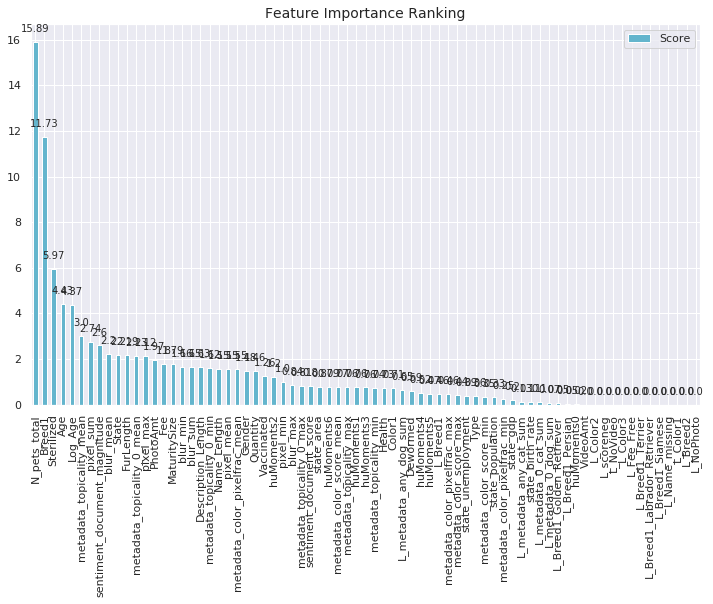

In [101]:
# plotMostRelevantFeatures(X_train.dtypes.index, bestClf, X_train_pool, y_train.astype('int').values)

### Feature engineering

Sentiment Analysis Data

In [102]:
# targetSentiment = 'AdoptionSpeed'
# categoricalFeaturesSentiment = ['Type', 'Breed1', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
#                        'Health']
# numericalFeaturesSentiment = ['Age', 'Quantity', 'Fee', 'PhotoAmt', 'VideoAmt', 'sentiment_document_score', 'sentiment_document_magnitude']

# trying new set of features from different models
# categoricalFeaturesSentiment = ['Breed1', 'Sterilized', 'Vaccinated', 'MaturitySize', 'Gender']
# numericalFeaturesSentiment = ['sentiment_document_magnitude', 'Age', 'PhotoAmt', 'Quantity']

In [103]:
# msno.matrix(train[categoricalFeaturesSentiment + numericalFeaturesSentiment])

In [104]:
# params = {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 12, 'learning_rate': 0.15}

# (clfSentiment, 
#  y_predicted, 
#  X_train, 
#  y_train, 
#  X_train_pool,
#  X_test_pool,
#  y_test) = trainCatboost(numericalFeaturesSentiment, categoricalFeaturesSentiment, targetSentiment, train[categoricalFeaturesSentiment + numericalFeaturesSentiment + [targetSentiment]].dropna(), params)

In [105]:
# scores = calculateClassificationScores(y_test, y_predicted, clfSentiment, X_test_pool)
# print('accuracy: %f f1: %f precision: %f recall: %f multiclass: %f' % scores )

In [106]:
# generateConfusionMatrix(y_test, y_predicted)

In [107]:
# plotMostRelevantFeatures(X_train.dtypes.index, bestClf, X_train_pool, y_train.astype('int').values)

In [108]:
# search best params for new features
# params = {
#     'depth':[6, 8, 10, 12],
#     'iterations':[100, 150, 300],
#     'learning_rate':[0.15], 
#     'l2_leaf_reg':[12]
# }

# grid = ParameterGrid(params)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#dataS = train[numericalFeaturesSentiment + categoricalFeaturesSentiment + [targetSentiment]].dropna()

#bestScores = []
#X = dataS[numericalFeaturesSentiment + categoricalFeaturesSentiment]
#y = dataS[targetSentiment]

#catboostDf = searchBestParams(grid, X, y)
#bestCatModel = catboostDf[catboostDf.f1_score_mean == catboostDf.f1_score_mean.max()]
#bestCatModel.params.values[0]

{'depth': 6, 'iterations': 300, 'l2_leaf_reg': 12, 'learning_rate': 0.15}

In [109]:
#bestCatModel.f1_score_mean

In [110]:
# data['AgeInterval'] = pd.Series(['0-3', '3-6', '6-12', '12-24', '24-48', '48-120', '>120'], dtype='category')
# data.loc[(data['Age'] >= 0) & (data['Age'] <= 3),'AgeInterval'] = '0-3'
# data.loc[(data['Age'] > 3) & (data['Age'] <= 6),'AgeInterval'] = '3-6'
# data.loc[(data['Age'] > 6) & (data['Age'] <= 12),'AgeInterval'] = '6-12'
# data.loc[(data['Age'] > 12) & (data['Age'] <= 24),'AgeInterval'] = '12-24'
# data.loc[(data['Age'] > 24) & (data['Age'] <= 48),'AgeInterval'] = '24-48'
# data.loc[(data['Age'] > 48) & (data['Age'] <= 120),'AgeInterval'] = '48-120'
# data.loc[data['Age'] > 120,'AgeInterval'] = '>120'

In [111]:
# target = 'AdoptionSpeed'
# categoricalFeatures = ['Type', 'Breed1', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
#                        'Health', 'AgeInterval']
# numericalFeatures = ['Age', 'Quantity', 'Fee', 'PhotoAmt', 'VideoAmt']

# (model, 
#  y_predicted, 
#  X_train, 
#  y_train, 
#  X_train_pool, 
#  X_test_pool) = trainCatboost(numericalFeatures, categoricalFeatures, target, data)

In [112]:
# scores = calculateClassificationScores(y_test, y_predicted, model, X_test_pool)
# print('accuracy: %f f1: %f precision: %f recall: %f multiclass: %f' % scores )

In [113]:
# plotMostRelevantFeatures(X_train.dtypes.index, bestClf, X_train_pool, y_train.astype('int').values)

Train model for submission

In [114]:
# dataS = train[numericalFeatures + categorical + [target]].dropna()

# X = dataS[numericalFeatures + categorical]
# y = dataS[target]

# prepare data for catboost
# X_train = FeaturesData(
#     num_feature_data=X[numericalFeatures].astype('float32').values,
#     cat_feature_data=X[categorical].__array__(dtype=object)
# )
# y_train = y.astype('int').values

# best model is with sentiment data {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 12, 'learning_rate': 0.15}
# bestClf = CatBoostClassifier(
#             loss_function='MultiClass',
#             verbose=False,
#             depth=8,
#             iterations=140,
#             l2_leaf_reg=12,
#             learning_rate=0.15,
#             task_type='CPU',
#             class_weights=[4, 1, 1, 1, 1]
#         )
        
# bestClf.fit(X_train, y_train,logging_level='Silent')

In [115]:
# transforming test as we transformed train
# testClean = cleanTransformDataset(test)
# testClean.head()

In [116]:
def generateSubmissionCatboost(model, numericalFeatures, categoricalFeatures,fileName):
    X = test[numericalFeatures + categoricalFeatures]
    X = FeaturesData(
            num_feature_data=X[numericalFeatures].astype('float32').values,
            cat_feature_data=X[categoricalFeatures].__array__(dtype=object)
        )
    predictions = model.predict(X)
    test['AdoptionSpeed'] = predictions
    test.AdoptionSpeed = test['AdoptionSpeed'].map({0.0: '0', 1.0: '1', 2.0: '2', 3.0: '3', 4.0: '4'})
    test[['PetID', 'AdoptionSpeed']].to_csv(fileName + '.csv', index=False)

In [117]:
# generateSubmissionCatboost(bestClf, numericalFeatures, categorical, 'submission')

Random Forest

In [118]:
# X_train, X_test, y_train, y_test = train_test_split(
#     pd.get_dummies(X),
#     y.astype('int64'),
#     test_size=0.25,
#     random_state=42
# )

# rf = RandomForestClassifier()

# rf.fit(X_train, y_train)
# y_predicted = rf.predict(X_test)

In [119]:
# scores = calculateClassificationScores(y_test, y_predicted, rf, X_test)
# print('accuracy: %f f1: %f precision: %f recall: %f' % scores )

In [120]:
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(6, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [121]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
# rf_random.fit(X_train, y_train)

In [122]:
# y_predicted = rf_random.predict(X_test)
# scores = calculateClassificationScores(y_test, y_predicted, rf_random, X_test)
# print('accuracy: %f f1: %f precision: %f recall: %f' % scores )

In [123]:
# rf_random.best_params_

In [124]:
# generateConfusionMatrix(y_test, y_predicted)

AdaBoost

In [125]:
# ab = AdaBoostClassifier()
# ab.fit(X_train, y_train)

In [126]:
# y_predicted = ab.predict(X_test)
# scores = calculateClassificationScores(y_test, y_predicted, ab, X_test)
# print('accuracy: %f f1: %f precision: %f recall: %f' % scores )

GradientBoosting

In [127]:
# gb = GradientBoostingClassifier()
# gb.fit(X_train, y_train)

In [128]:
# y_predicted = gb.predict(X_test)
# scores = calculateClassificationScores(y_test, y_predicted, gb, X_test)
# print('accuracy: %f f1: %f precision: %f recall: %f' % scores )

XGBoost

In [129]:
# param = {'max_depth':8, 'eta':0.15, 'silent':1, 'objective':'multi:softmax' }
# num_round = 140
# xgbModel = xgb.XGBClassifier(max_depth=8, n_estimators=140, learning_rate=0.15)
# xgbModel.fit(X_train, y_train)

Voting ensembler

In [130]:
# vc = VotingClassifier(estimators=[('cb', bestClf), ('rf', rf_random), ('ab', ab), ('gb', gb) ], voting='hard')
# vc = vc.fit(X_train, y_train)

In [131]:
# y_predicted = vc.predict(X_test)
# scores = calculateClassificationScores(y_test, y_predicted, vc, X_test)
# print('accuracy: %f f1: %f precision: %f recall: %f' % scores )  

### XGBoost and OptimizeRounder with Kappa Loss

In [34]:
X_train_non_null = trainPrecomputed.fillna(-1)
X_test_non_null = testPrecomputed.fillna(-1)

In [35]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

#### Optimze coefficients based on kappa loss. Final competition metric

In [36]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [37]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.0123,
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'tree_method': 'auto',
    'device': 'cpu',
    'silent': 1,
}

In [38]:
def run_xgb(params, X_train, X_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 60000
    early_stop = 500

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))

    i = 0

    for train_idx, valid_idx in kf.split(X_train, X_train['AdoptionSpeed'].values):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = X_tr['AdoptionSpeed'].values
        X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)

        y_val = X_val['AdoptionSpeed'].values
        X_val = X_val.drop(['AdoptionSpeed'], axis=1)

        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                         early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)

        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)

        oof_train[valid_idx] = valid_pred
        oof_test[:, i] = test_pred

        i += 1
    return model, oof_train, oof_test

In [ ]:
model, oof_train, oof_test = run_xgb(xgb_params, X_train_non_null, X_test_non_null)

In [ ]:
def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={'range': [0, 5]})

In [ ]:
plot_pred(oof_train)

In [ ]:
plot_pred(oof_test.mean(axis=1))

In [ ]:
optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, valid_pred)
print("QWK = ", qwk)

In [ ]:
coefficients_ = coefficients.copy()
coefficients_[0] = 1.66
coefficients_[1] = 2.13
coefficients_[3] = 2.85
train_predictions = optR.predict(oof_train, coefficients_).astype(np.int8)
print(f'train pred distribution: {Counter(train_predictions)}')
test_predictions = optR.predict(oof_test.mean(axis=1), coefficients_).astype(np.int8)
print(f'test pred distribution: {Counter(test_predictions)}')

In [ ]:
Counter(train_predictions)

In [ ]:
Counter(test_predictions)

In [ ]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

**Future work:**
* Down sampling
* Weghts classes
* Compare with Random Forest and Boosting models
* Combine models with Voting and other techniques